In [1]:
import os
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axisartist.axislines import AxesZero
from scipy import signal, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

Load CCF for identifying cortical areas

In [6]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [7]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [8]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
#     'VIS-TH': [
#         'LD', 'LGd-sh', 'LGd-co', 'LGd-ip', 'LGv', 'LP', 'MGd', 'MGm', 'MGv'
#     ] # CK said MGd/m/v is auditory?
}

In [9]:
area_colors = {
    'MO': 'blue',
    'ACA': 'deepskyblue',
    'SS': 'blueviolet',
    'VIS': 'green',
    'MO-TH': 'steelblue',
#     'VIS-TH': 'olivedrab'
}

## Using colors from AllenSDK makes them too similar ##
# area_colors = {}
# for area in areas_of_interest.keys():
#     try:
#         area_colors[area] = tuple(np.array(str_tree.get_structures_by_acronym([area])[0]['rgb_triplet'])/255)
#     except KeyError:
#         area_colors[area] = tuple(np.array(str_tree.get_structures_by_acronym([areas_of_interest[area][0]])[0]['rgb_triplet'])/255)

#### Functions

In [10]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

### Define data path

In [11]:
rec_folder = r'F:\EEG_exp\mouse569062\estim_vis_2021-02-18_11-17-51\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


In [12]:
# Make a folder in my OneDrive to save plots
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)
    
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

estim_vis


#### Load EEG data

In [13]:
## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(exp.mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(exp.experiment_folder))))
)].squeeze()

## Get bad_ch_list from metadata ##
badchstr = exp_meta['EEG bad_channels'].replace(' ','')
bad_chs = []
for char in badchstr.split(','):
    if char.isdecimal():
        bad_chs.append(int(char))
        
 ## Get PCI_stim_amp from metadata ##
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
if len(currents_list) > 1:
    PCI_stim_amp = currents_list[1]
elif len(currents_list) == 1:
    PCI_stim_amp = currents_list[0]
else:
    print('No stim current listed in Zap_Zip-log_exp')
print(PCI_stim_amp)

35


In [14]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])

# bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

#### Load stim table and get good EEG channels

In [15]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good
0,biphasic,35,310.40707,310.40747,0.0004,0,True
1,biphasic,15,313.94009,313.94049,0.0004,0,True
2,biphasic,35,318.00171,318.00211,0.0004,0,True
3,biphasic,60,322.38399,322.38439,0.0004,0,True
4,biphasic,60,326.55359,326.55399,0.0004,0,True


In [16]:
state_sweeps = {'awake': [0], 'anesthetized': [1]}

In [17]:
run_signal, run_timestamps = exp.load_running()

#### Load unit data

In [18]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeD', 'probeF']


In [19]:
probe_unit_data = {}
total_units = 0
for probei in probe_list:
    print(probei)
    probe_unit_data[probei] = {}
    
    ## Load probe_info.json ##
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
    print(' surface channel: {:d}'.format(surface_ch))
    
    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    probe_unit_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    
    ## Select units and get peak chs ##
    select_units, peak_chs, unit_metrics = exp.get_probe_units(probei)
    unit_metrics['cell_type'] = unit_metrics['duration'].apply(lambda x: 'FS' if x <= 0.4 else 'RS')
    print(' unit count: {:d}'.format(len(select_units)))
    
    ## Sort units ##
    all_units = select_units[np.squeeze(np.argsort(peak_chs))]
    all_units_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
    all_units_types = unit_metrics['cell_type'].values[np.squeeze(np.argsort(peak_chs))]
    probe_unit_data[probei]['units'] = all_units
    probe_unit_data[probei]['chs'] = all_units_chs
    probe_unit_data[probei]['cell_type'] = all_units_types
    if 'area' in unit_metrics.columns:
        all_units_areas = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
        probe_unit_data[probei]['areas_assigned'] = True
        probe_unit_data[probei]['areas'] = all_units_areas
    else:
        print(' unit metrics file does not have area assignments.')
        probe_unit_data[probei]['areas_assigned'] = False
    total_units += len(probe_unit_data[probei]['units'])
            
    ## Load spike times and cluster ids ##
    probe_unit_data[probei]['spike_times'] = np.load(exp.ephys_params[probei]['spike_times'])
    probe_unit_data[probei]['spike_clusters'] = np.load(exp.ephys_params[probei]['spike_clusters'])
print('Total unit count: {:d}'.format(total_units))

probeB
 surface channel: 330
 unit count: 280
probeD
 surface channel: 345
 unit count: 331
probeF
 surface channel: 265
 unit count: 291
Total unit count: 902


## Population responses

### Loop one stimulus, one sweep only

In [20]:
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic', 'circle'
plstate = 'awake'
plamp = '35'
# amp_list = sorted(stim_log[stim_log['stim_type']==stim_type].parameter.unique(), key=lambda x: int(x))
# print(amp_list)

before_event = 1.0 # time before event, s
after_event = 1.0 # time after event, s

## EEG params ##
apply_mask = True
apply_car = True

## Unit params ##
plot_timebin = 0.005 # s

In [21]:
EEG_traces = {}
pop_activity = {key: [] for key in list(areas_of_interest.keys())}

## Mask estim artifact ##
if apply_mask:
    mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
    for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
        val = find_nearest_ind(eeg_ts, etime) - 2
        eeg_data[val:val+mask_samples, :] = eeg_data[val:val-mask_samples:-1, :]

start = time.time()

## Get events ##
state_events = []
for sweepi in state_sweeps[plstate]:
    events = get_stim_events(stim_log, stim_type, plamp, sweepi)
    if len(events) == 0:
        continue
    state_events.append(events)
state_events = np.concatenate(state_events)

## Get mean speed ##
rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
rest_events = np.nonzero(mean_speed == 0)[0]
print('{} state: resting trials {:d}/{:d}'.format(plstate, len(rest_events), len(state_events)))

## EEG traces ##
eeg_event_traces, eeg_event_ts = get_evoked_traces(
    eeg_data,
    eeg_ts,
    state_events[rest_events],
    before_event,
    after_event,
    exp.ephys_params['EEG']['sample_rate']
)
## Common average reference ##
if apply_car:
    eeg_event_traces = eeg_event_traces - np.mean(eeg_event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]

## Design and apply Butterworth filter ##
filtb, filta = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')
EEG_traces[plamp] = [eeg_event_ts, np.mean(signal.filtfilt(filtb, filta, eeg_event_traces, axis=0), axis=2)]


## Units ##
# get evoked firing rates for all units
total_units = 0
for probei, unit_data in probe_unit_data.items():
    event_trig_FR, spikerate_ts = get_evoked_firing_rates(
        unit_data['spike_times'],
        unit_data['spike_clusters'],
        unit_data['units'],
        state_events[rest_events],
        before_event,
        after_event,
        plot_timebin
    )
    
    # get population activity
    for unitind in range(event_trig_FR.shape[0]):
        parent_region = [key for key in list(areas_of_interest.keys()) if unit_data['areas'][unitind] in areas_of_interest[key]]
        if len(parent_region) == 1:
            pop_activity[parent_region[0]].append(event_trig_FR[unitind,:])

    total_units += event_trig_FR.shape[1]

end = time.time()
print('{}: {:.2f} s'.format(plamp, (end - start)))

awake state: resting trials 102/120
35: 35.16 s


<IPython.core.display.Javascript object>


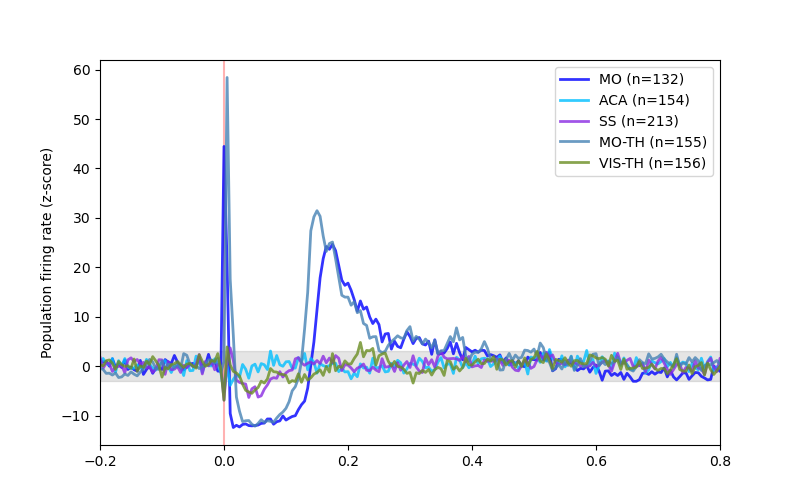

In [22]:
pwin = [-0.2, 0.8]
fig, ax = plt.subplots(figsize=(8,5))
ax.axvline(0, color='r', alpha=0.3)
ax.axhspan(-3,3, color='k', alpha=0.1)
for region, popdata in pop_activity.items():
#     print(region)
    if len(popdata) == 0:
        continue
    pop_FR = np.vstack(popdata)
    if pop_FR.shape[0] < 20:
        popline = 'dotted'
    else:
        popline = 'solid'
    pop_avg = np.mean(pop_FR, axis=0)
    BL_bins = spikerate_ts < 0
    pop_Z = (pop_avg - np.mean(pop_avg[BL_bins[:-1]], axis=0)) / np.std(pop_avg[BL_bins[:-1]], axis=0)
    ax.plot(
        spikerate_ts[:-1], pop_Z, color=area_colors[region], linewidth=2, linestyle=popline, alpha=0.8,
        label='{} (n={:d})'.format(region, pop_FR.shape[0])
    )
ax.set_xlim(pwin)
ax.set_ylabel('Population firing rate (z-score)')
ax.legend()

## Plot one amplitude, multiple states

Get trial times and counts

In [20]:
state_colors = {'awake': 'olivedrab', 'anesthetized': 'slateblue'}

In [21]:
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic'
plstim = PCI_stim_amp

rest_trials_only = True

all_event_times = {}
all_trial_counts = {}
state_trial_count = []
for statei, sweeps in state_sweeps.items():

    ## Get all event times for statei ##
    state_events = []
    for sweepi in sweeps:
        events = get_stim_events(stim_log, stim_type, plstim, sweepi)
        if len(events) == 0:
            continue
        state_events.append(events)
    state_events = np.concatenate(state_events)

    ## Get mean speed for all events ##
    rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
    event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
    mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
    rest_events = np.nonzero(mean_speed == 0)[0]
    print('{} state: resting trials {:d}/{:d}'.format(statei, len(rest_events), len(state_events)))
    state_trial_count.append(len(rest_events))

    if rest_trials_only:
        all_event_times[statei] = state_events[rest_events]
    else:
        all_event_times[statei] = state_events
all_trial_counts = state_trial_count

awake state: resting trials 102/120
anesthetized state: resting trials 119/120


Gather unit firing rates and population avg

In [22]:
before_event = 1.0 # time before event, s
after_event = 1.0 # time after event, s

plot_timebin = 0.005 # s

In [25]:
all_pop_activity = {}
NUM_TRIALS = min(all_trial_counts)
for statei, event_times in all_event_times.items():
    all_pop_activity[statei] = {key: {'RS': [], 'FS': []} for key in list(areas_of_interest.keys())}
    for probei, unit_data in probe_unit_data.items():
        event_trig_FR, spikerate_ts = get_evoked_firing_rates(
            unit_data['spike_times'],
            unit_data['spike_clusters'],
            unit_data['units'],
            event_times[:NUM_TRIALS],
            before_event,
            after_event,
            plot_timebin
        )

        for unitind in range(event_trig_FR.shape[0]):
            parent_region = [
                key for key in list(areas_of_interest.keys()) if unit_data['areas'][unitind] in areas_of_interest[key]
            ]
            if len(parent_region) == 1 and unit_data['cell_type'][unitind] == 'RS':
                all_pop_activity[statei][parent_region[0]]['RS'].append(event_trig_FR[unitind,:])
            elif len(parent_region) == 1 and unit_data['cell_type'][unitind] == 'FS':
                all_pop_activity[statei][parent_region[0]]['FS'].append(event_trig_FR[unitind,:])

Plot all trial types

<IPython.core.display.Javascript object>


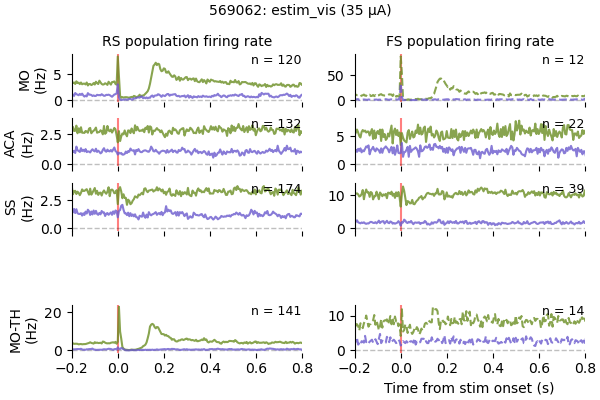

In [41]:
## Population firing rate of RS and FS cells ##
plwin = [-0.2, 0.8]
cell_types = ['RS', 'FS']

fig, axs = plt.subplots(len(areas_of_interest), len(cell_types), figsize=(6,4), sharex=True, constrained_layout=True)

for rowi, region in enumerate(areas_of_interest.keys()):
#     print(region)
    for coli, typei in enumerate(cell_types):
        axs[rowi,coli].spines['bottom'].set_visible(False)
        axs[rowi,coli].spines['top'].set_visible(False)
        axs[rowi,coli].spines['right'].set_visible(False)
        for statei in all_pop_activity.keys():
            popdata = all_pop_activity[statei][region][typei]
#             print(' {} - {} units'.format(statei, len(popdata)))
            if len(popdata) < 5:
    #             axs[rowi,coli].spines['left'].set_visible(False)
    #             axs[rowi,coli].set_xticks([])
    #             axs[rowi,coli].set_yticks([])
                if statei == 'awake':
                    axs[rowi,coli].remove()
                continue
            pop_FR = np.vstack(popdata)

            if statei == 'awake':
                axs[rowi,coli].axvline(0, color='r', linewidth=1.5, alpha=0.5)
                axs[rowi,coli].axhline(0, color='k', linewidth=1, linestyle='dashed', alpha=0.25)
                axs[rowi,coli].text(
                    1, 1, ('n = {:d}'.format(pop_FR.shape[0])),
                    ha='right', va='top', fontsize=9, transform=axs[rowi,coli].transAxes
                )
#                 axs[rowi,coli].axhline(3, color='k', linewidth=1, linestyle='dashed', alpha=0.25)
#                 axs[rowi,coli].axhline(-3, color='k', linewidth=1, linestyle='dashed', alpha=0.25)
#                 if rowi == 0:
#                     axs[rowi,coli].text(
#                     plwin[1], 3, 'z = 3', horizontalalignment='right', verticalalignment='bottom', fontsize=8)

            if pop_FR.shape[0] < 20:
                popline = 'dashed'
            else:
                popline = 'solid'
            pop_avg = np.mean(pop_FR, axis=0)
#             BL_bins = spikerate_ts < 0
#             pop_Z = (pop_avg - np.mean(pop_avg[BL_bins[:-1]], axis=0)) / np.std(pop_avg[BL_bins[:-1]], axis=0)
#             axs[rowi,coli].plot(
#                 spikerate_ts[:-1], pop_Z, color=state_colors[statei], linestyle=popline, linewidth=1.5, alpha=0.8, label=statei
#             )
            axs[rowi,coli].plot(
                spikerate_ts[:-1], pop_avg, color=state_colors[statei],
                linestyle=popline, linewidth=1.5, alpha=0.8, label=statei
            )
            axs[rowi,coli].set_xlim(plwin)
    #         axs[rowi,coli].set_ylim([-10,25])
#             axs[rowi,coli].set_ylabel('{}\n(Hz)'.format(region))
            if coli == 0:
                axs[rowi,coli].set_ylabel('{}\n(Hz)'.format(region))
#             else:
#                 axs[rowi,coli].set_ylabel('(Hz)')

            if rowi == 0:
                axs[rowi,coli].set_title('{} population firing rate'.format(typei))
    #             axs[rowi,coli].legend()

axs[rowi,coli].set_xlabel('Time from stim onset (s)')
plt.suptitle('{}: {} ({} \u03bcA)'.format(exp.mouse, exp_tag, plstim), fontsize=10)
## Save ##
figname = 'popFR_RS-FS_rest-iso_{}_{}.png'.format(exp_tag, plstim)
fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

## Plot multiple trial types

Get trial times and counts

In [30]:
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic'
comp_states = {
    'MOs_1200': {'awake': [0], 'anesthetized': [1]},
}

rest_trials_only = True
amp_list = sorted(stim_log[stim_log['stim_type']==stim_type].parameter.unique(), key=lambda x: int(x))

all_event_times = {}
all_trial_counts = {}
for expdes, state_sweeps in comp_states.items():
    print(expdes)
    all_event_times[expdes] = {}
    all_trial_counts[expdes] = {}
    for parami in amp_list:
        print(' biphasic - {} \u03bcA'.format(parami))
        all_event_times[expdes][parami] = {}
        state_trial_count = []
        for statei, sweeps in state_sweeps.items():
            
            ## Get all event times for statei ##
            state_events = []
            for sweepi in sweeps:
                events = get_stim_events(stim_log, stim_type, parami, sweepi)
                if len(events) == 0:
                    continue
                state_events.append(events)
            state_events = np.concatenate(state_events)
            
            ## Get mean speed for all events ##
            rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
            event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
            mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
            rest_events = np.nonzero(mean_speed == 0)[0]
            print('  {} state: resting trials {:d}/{:d}'.format(statei, len(rest_events), len(state_events)))
            state_trial_count.append(len(rest_events))
            
            if rest_trials_only:
                ## Keep resting event times ##
                all_event_times[expdes][parami][statei] = state_events[rest_events]
            else:
                all_event_times[expdes][parami][statei] = state_events
        all_trial_counts[expdes][parami] = state_trial_count

MOs_1200
 biphasic - 15 μA
  awake state: resting trials 94/120
  anesthetized state: resting trials 120/120
 biphasic - 35 μA
  awake state: resting trials 102/120
  anesthetized state: resting trials 119/120
 biphasic - 60 μA
  awake state: resting trials 90/120
  anesthetized state: resting trials 120/120


Gather unit firing rates and population avg

In [31]:
before_event = 1.0 # time before event, s
after_event = 1.0 # time after event, s

plot_timebin = 0.005 # s

In [32]:
all_pop_activity = {}
for expdes in all_event_times.keys():
    print(expdes)
    all_pop_activity[expdes] = {}
    for parami in all_event_times[expdes].keys():
        all_pop_activity[expdes][parami] = {}
        NUM_TRIALS = min([len(all_event_times[expdes][parami][x]) for x in all_event_times[expdes][parami].keys()])
        for statei, event_times in all_event_times[expdes][parami].items():
            all_pop_activity[expdes][parami][statei] = {key: [] for key in list(areas_of_interest.keys())}
            for probei, unit_data in probe_unit_data.items():
                event_trig_FR, spikerate_ts = get_evoked_firing_rates(
                    unit_data['spike_times'],
                    unit_data['spike_clusters'],
                    unit_data['units'],
                    event_times[:NUM_TRIALS],
                    before_event,
                    after_event,
                    plot_timebin
                )

                for unitind in range(event_trig_FR.shape[0]):
                    parent_region = [key for key in list(areas_of_interest.keys()) if unit_data['areas'][unitind] in areas_of_interest[key]]
                    if len(parent_region) == 1:
                        all_pop_activity[expdes][parami][statei][parent_region[0]].append(event_trig_FR[unitind,:])

MOs_1200


Plot all trial types

<IPython.core.display.Javascript object>


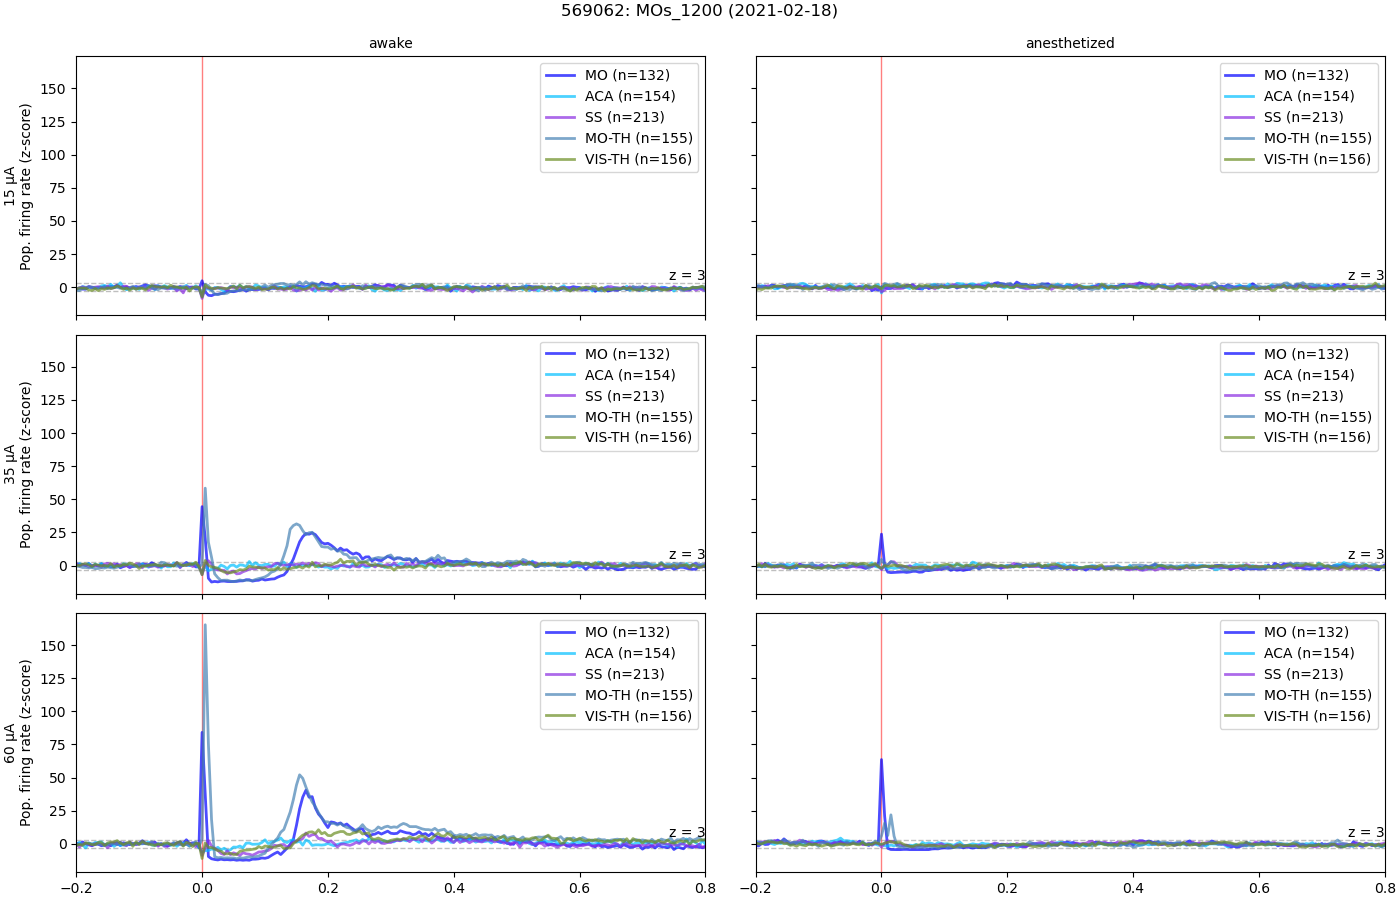

In [34]:
plwin = [-0.2, 0.8]

for expdes in all_pop_activity.keys():
    fig, axs = plt.subplots(3, 2, figsize=(14,9), sharex=True, sharey=True, constrained_layout=True)
    for rowi, (paramii, paramdict) in enumerate(all_pop_activity[expdes].items()):
        for coli, (statei, datai) in enumerate(paramdict.items()):
            
            axs[rowi,coli].axvline(0, color='r', linewidth=1, alpha=0.5)
            axs[rowi,coli].axhline(3, color='k', linewidth=1, linestyle='dashed', alpha=0.25)
            axs[rowi,coli].axhline(-3, color='k', linewidth=1, linestyle='dashed', alpha=0.25)
            for region, popdata in datai.items():
                if len(popdata) == 0:
                    continue
                pop_FR = np.vstack(popdata)
                if pop_FR.shape[0] < 20:
                    popline = 'dotted'
                else:
                    popline = 'solid'
                pop_avg = np.mean(pop_FR, axis=0)
                BL_bins = spikerate_ts < 0
                pop_Z = (pop_avg - np.mean(pop_avg[BL_bins[:-1]], axis=0)) / np.std(pop_avg[BL_bins[:-1]], axis=0)
                axs[rowi,coli].plot(
                    spikerate_ts[:-1], pop_Z, color=area_colors[region], linewidth=2, linestyle=popline, alpha=0.7,
                    label='{} (n={:d})'.format(region, pop_FR.shape[0])
                )
            axs[rowi,coli].set_xlim(plwin)
            axs[rowi,coli].legend()
            axs[rowi,coli].text(plwin[1], 3, 'z = 3', horizontalalignment='right', verticalalignment='bottom', fontsize=10)
            
            if coli == 0:
                axs[rowi,coli].set_ylabel('{} \u03bcA\nPop. firing rate (z-score)'.format(paramii))
                
            if rowi == 0:
                axs[rowi,coli].set_title(statei)
            
    plt.suptitle('{}: {} ('.format(exp.mouse, expdes) + exp.date.strftime('%Y-%m-%d') + ')', fontsize=12)
    ## Save ##
    figname = 'Popactivity_summary_{}_{}.png'.format(exp_tag, expdes)
#     fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

# Do it for multiple subjects?

In [11]:
sub_dirs = {
    '551399': r'F:\EEG_exp\mouse551399\estim_2021-01-28_13-59-09\experiment1\recording1',
    '551397': r'F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1',
    '569062': r'F:\EEG_exp\mouse569062\estim_vis_2021-02-18_11-17-51\experiment1\recording1',
    '569068': r'F:\EEG_exp\mouse569068\estim_vis_2021-03-04_10-51-38\experiment1\recording1',
    '569069': r'F:\EEG_exp\mouse569069\estim_vis2_2021-03-12_10-52-44\experiment1\recording1',
    '569064': r'F:\EEG_exp\mouse569064\estim_vis_2021-04-08_10-28-24\experiment1\recording1',
    '569073a': r'F:\EEG_exp\mouse569073\estim_vis_2021-04-15_10-27-22\experiment1\recording1',
    '571619': r'F:\EEG_exp\mouse571619\estim2_2021-03-19_10-09-01\experiment1\recording1',
#     '569070': r'F:\EEG_exp\mouse569070\estim1_2021-04-01_10-27-33\experiment1\recording1', # no histology, brain not fixed
#     '543396': r'F:\EEG_exp\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1', # too few resting trials
    '546655': r'F:\EEG_exp\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1',
    '571618': r'F:\EEG_exp\mouse571618\estim1_2021-04-29_12-28-54\experiment1\recording1', # too many bad chs
    '575102': r'F:\EEG_exp\mouse575102\estim_vis_2021-06-03_11-25-01\experiment1\recording1',
#     '575100': r'F:\EEG_exp\mouse575100\estim_vis_2021-06-10_11-39-06\experiment1\recording1', # waiting for probeC areas
    '569073b': r'F:\EEG_exp\mouse569073\estim_2021-04-16_10-42-44\experiment1\recording1',
    '569072': r'F:\EEG_exp\mouse569072\estim_vis_2021-04-22_10-26-58\experiment1\recording1',
    '571620': r'F:\EEG_exp\mouse571620\estim_vis_2021-05-13_11-33-47\experiment1\recording1',
#     '582387': r'F:\EEG_exp\mouse582387\estim_vis_2021-07-22_09-59-47\experiment1\recording1', # no areas yet
}
## 9/2/21: all subjects except for 586466 and 586468 (who don't have area assignments yet anyway) ##

In [12]:
sub_exp_des = {
    '551399': {'MOs_1200': {'awake': [0], 'anesthetized': [1]}},
    '551397': {'MOs_1200': {'awake': [0], 'anesthetized': [1]}},
    '569062': {'MOs_1200': {'awake': [0], 'anesthetized': [1]}},
    '569068': {'MOs_1200': {'awake': [0], 'anesthetized': [1]}},
    '569069': {'MOs_1200': {'awake': [0], 'anesthetized': [1]}},
    '569064': {'MOs_1200': {'awake': [0], 'anesthetized': [1]}},
    '569073a': {'MOs_1220': {'awake': [0], 'anesthetized': [1]}},
    '571619': {'antMOs_500': {'awake': [0], 'anesthetized': [3]}, 'antMOs_1200': {'awake': [1], 'anesthetized': [2]}},
#     '569070': {'antMOs_800': {'awake': [0], 'anesthetized': [1]}, 'antMOs_1200': {'awake': [3], 'anesthetized': [2]}}, # no histology, brain not fixed
#     '543396': {'MOs_500': {'awake': [0], 'anesthetized': [1]}}, # too few resting trials
    '546655': {'MOs_600': {'awake': [0], 'anesthetized': [1]}},
    '571618': {'MOs_600': {'awake': [0], 'anesthetized': [1]}}, # too many bad chs
    '575102': {'MOs_500': {'awake': [0], 'anesthetized': [1]}},
#     '575100': {'MOs_400': {'awake': [0], 'anesthetized': [1]}}, # waiting for probeC areas
    '569073b': {'SSp_900': {'awake': [0], 'anesthetized': [1]}},
    '569072': {'SSp_1000': {'awake': [0], 'anesthetized': [1]}},
    '571620': {'SSp_500': {'awake': [0], 'anesthetized': [3]}, 'SSp_900': {'awake': [1], 'anesthetized': [2]}},
#     '582387': {'SSp_400': {'awake': [0], 'anesthetized': [3]}, 'SSp_900': {'awake': [1], 'anesthetized': [2]}}, # no areas yet
}

In [13]:
sub_exp = {}
for mousei, recdiri in sub_dirs.items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
Experiment type: electrical stimulation
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.


Parameters

In [14]:
before_event = 1.0 # time before event, s
after_event = 1.0 # time after event, s

plot_timebin = 0.005 # s
rest_trials_only = True

plwin = [-0.2, 0.8]

551399 - estim
 probeB
  unit count: 255
 probeF
  unit count: 338
 Total unit count: 593
 MOs_1200
 biphasic - 40 μA
  awake state: resting trials 109/118
  anesthetized state: resting trials 119/119
 biphasic - 60 μA
  awake state: resting trials 108/120
  anesthetized state: resting trials 120/120
 biphasic - 80 μA
  awake state: resting trials 106/120
  anesthetized state: resting trials 120/120


<IPython.core.display.Javascript object>


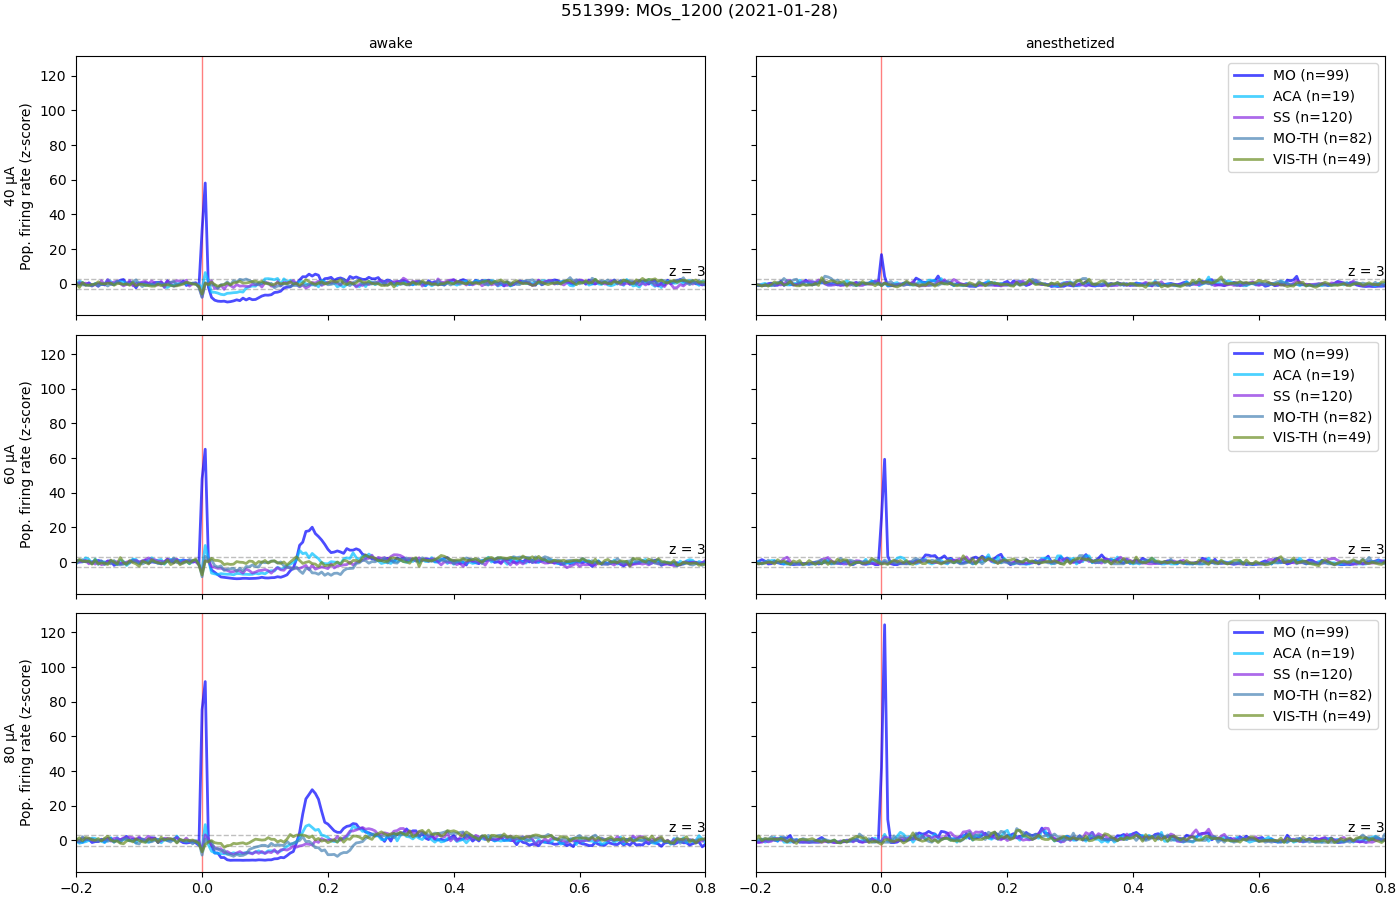

551397 - estim_vis
 probeB
  unit count: 331
 probeF
  unit count: 276
 Total unit count: 607
 MOs_1200
 biphasic - 10 μA
  awake state: resting trials 85/120
  anesthetized state: resting trials 120/120
 biphasic - 30 μA
  awake state: resting trials 96/120
  anesthetized state: resting trials 120/120
 biphasic - 50 μA
  awake state: resting trials 96/120
  anesthetized state: resting trials 120/120


<IPython.core.display.Javascript object>


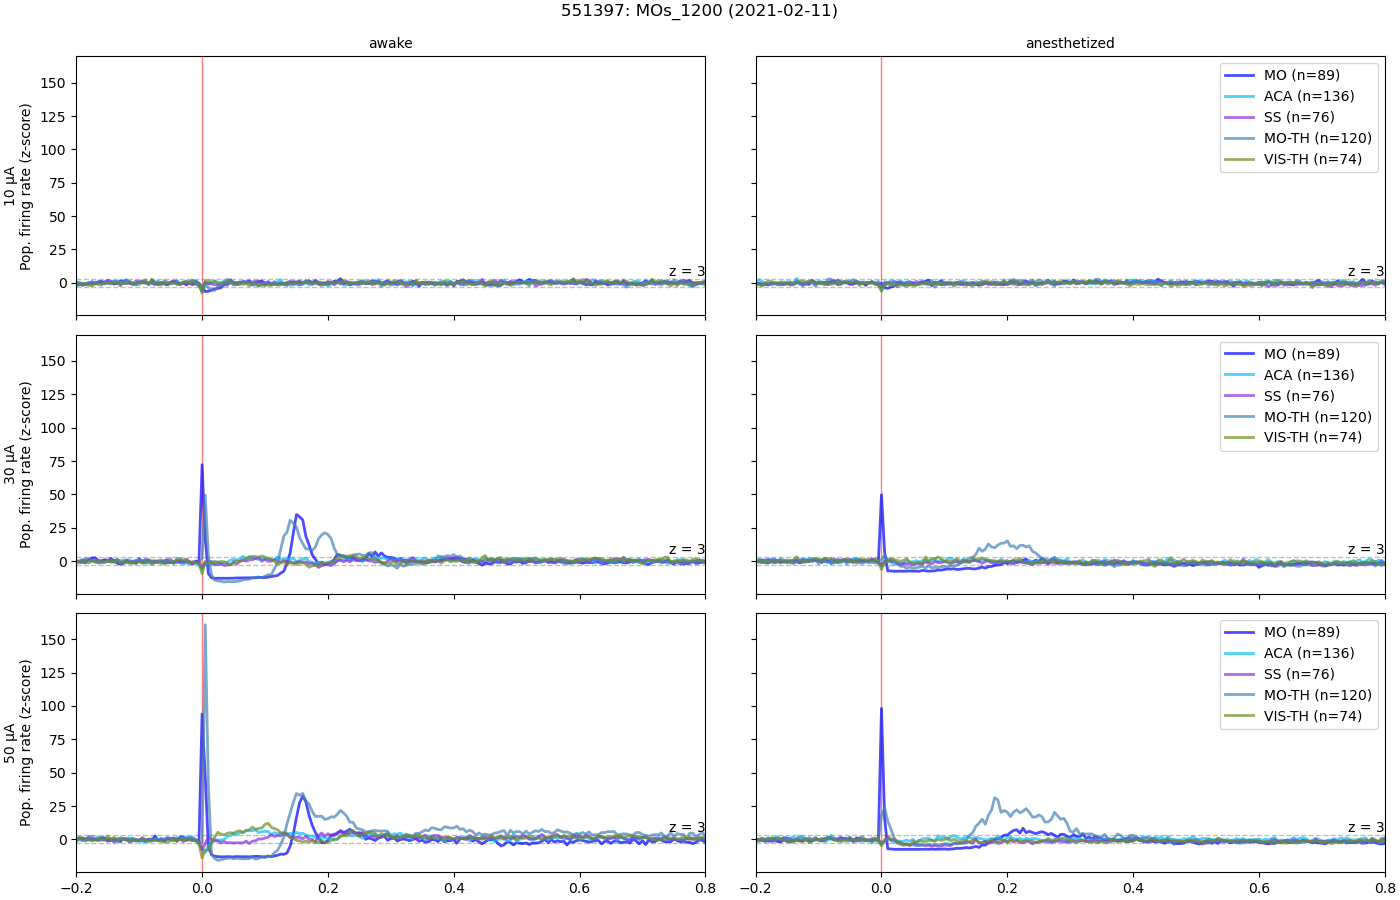

569062 - estim_vis
 probeB
  unit count: 280
 probeD
  unit count: 331
 probeF
  unit count: 291
 Total unit count: 902
 MOs_1200
 biphasic - 15 μA
  awake state: resting trials 94/120
  anesthetized state: resting trials 120/120
 biphasic - 35 μA
  awake state: resting trials 102/120
  anesthetized state: resting trials 119/120
 biphasic - 60 μA
  awake state: resting trials 90/120
  anesthetized state: resting trials 120/120


<IPython.core.display.Javascript object>


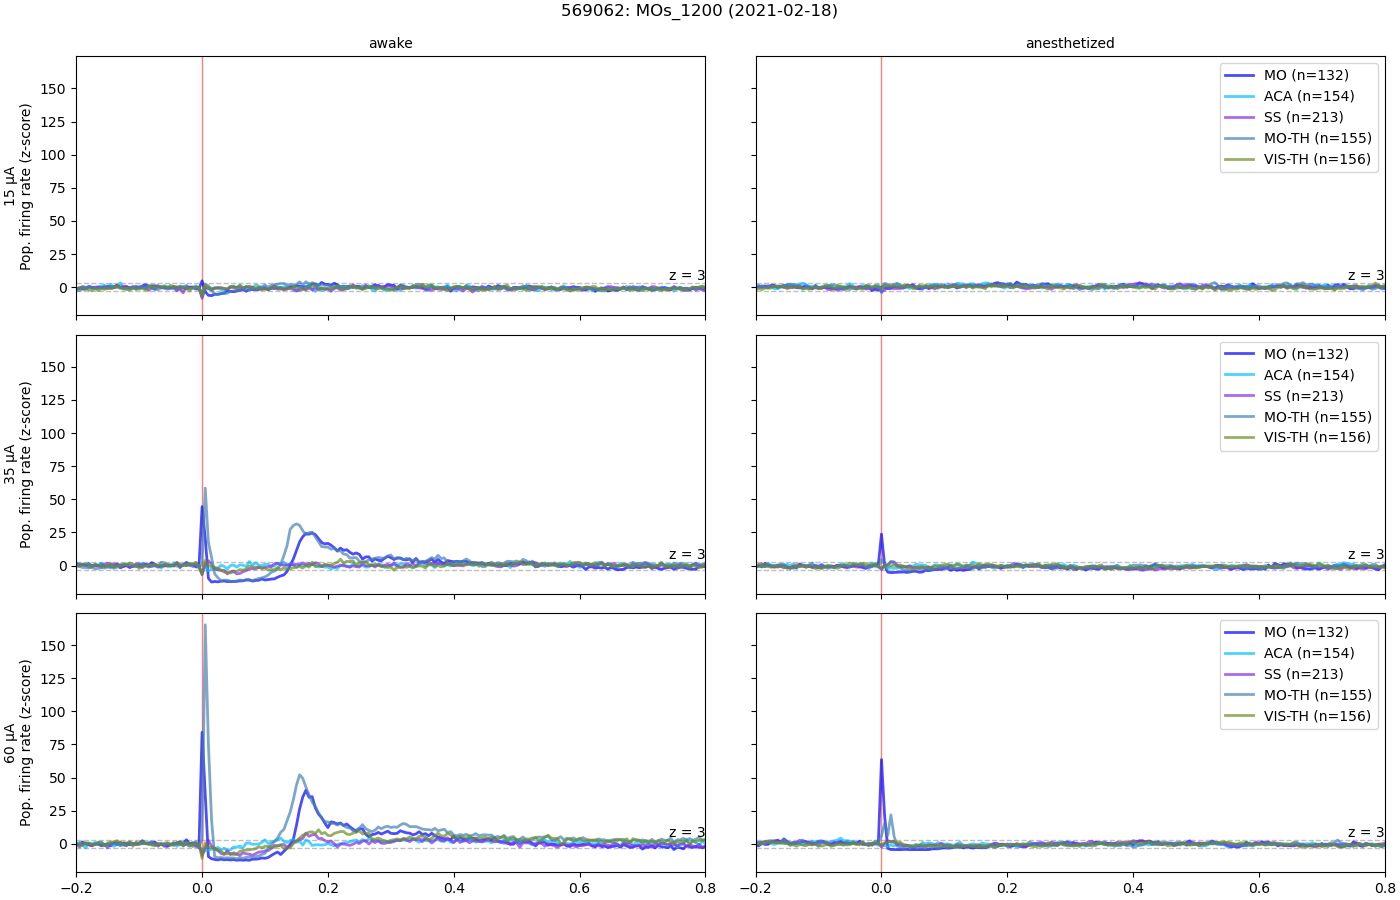

569068 - estim_vis
 probeB
  unit count: 216
 probeD
  unit count: 27
 probeF
  unit count: 95
 Total unit count: 338
 MOs_1200
 biphasic - 10 μA
  awake state: resting trials 96/119
  anesthetized state: resting trials 120/120
 biphasic - 20 μA
  awake state: resting trials 99/120
  anesthetized state: resting trials 119/119
 biphasic - 40 μA
  awake state: resting trials 100/120
  anesthetized state: resting trials 118/118


<IPython.core.display.Javascript object>


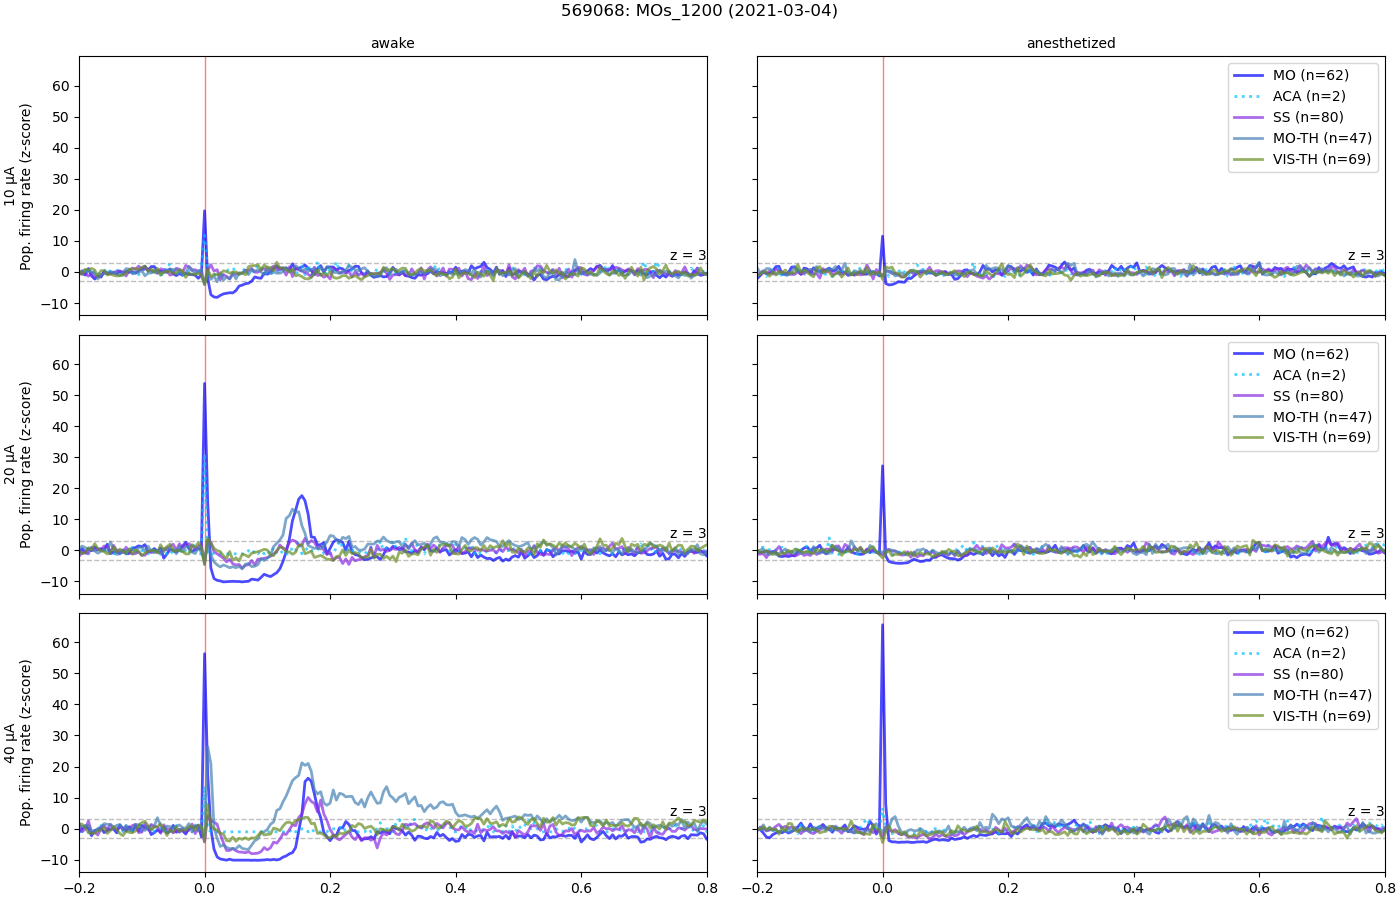

569069 - estim_vis2
 probeB
  unit count: 126
 probeC
  unit count: 292
 probeF
  unit count: 102
 Total unit count: 520
 MOs_1200
 biphasic - 20 μA
  awake state: resting trials 78/120
  anesthetized state: resting trials 120/120
 biphasic - 40 μA
  awake state: resting trials 82/119
  anesthetized state: resting trials 120/120
 biphasic - 70 μA
  awake state: resting trials 80/118
  anesthetized state: resting trials 119/119


<IPython.core.display.Javascript object>


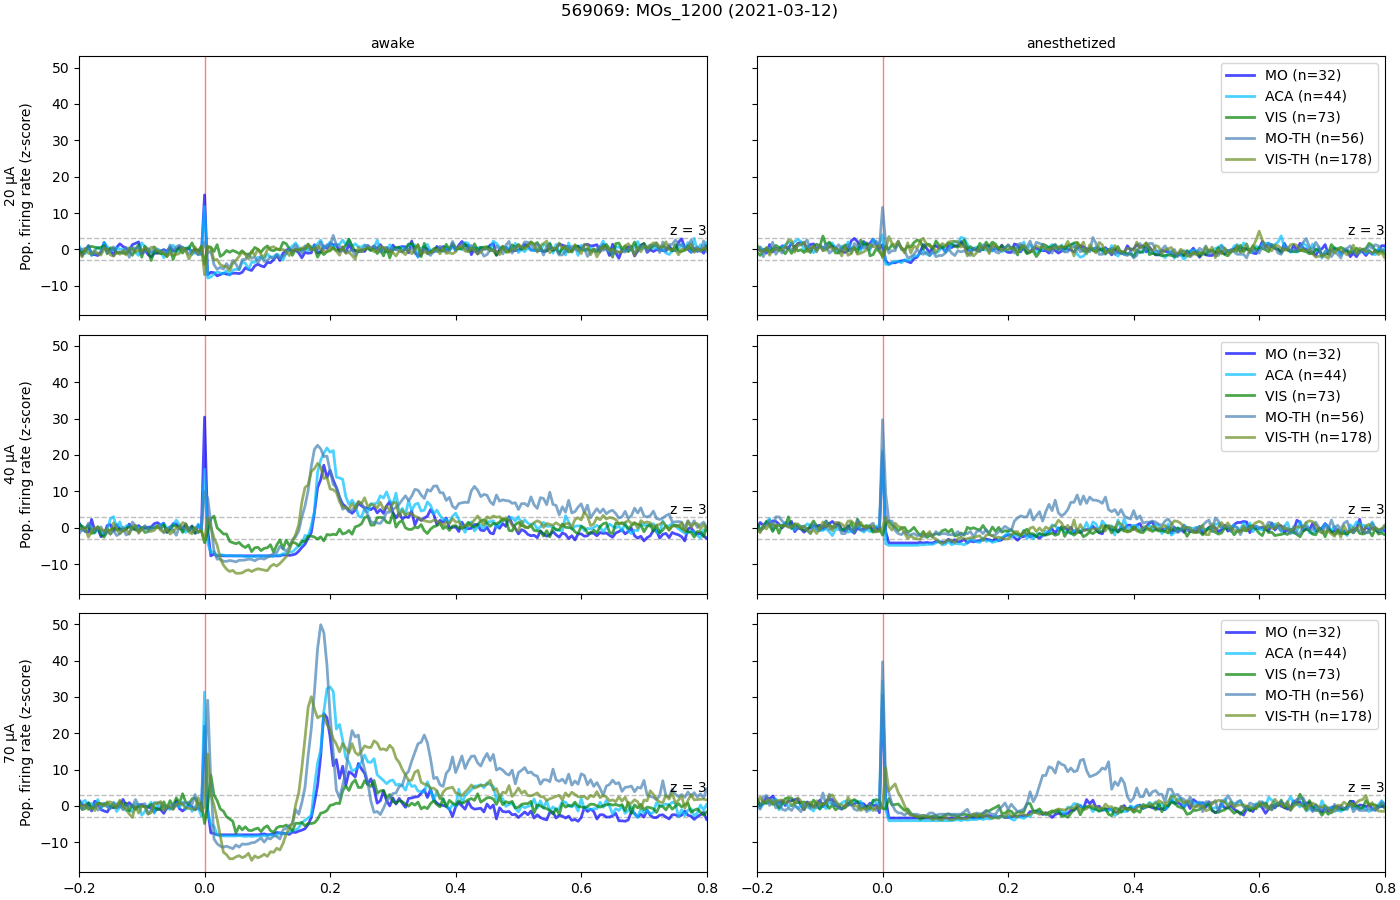

569064 - estim_vis
 probeB
  unit count: 84
 probeC
  unit count: 309
 probeF
  unit count: 88
 Total unit count: 481
 MOs_1200
 biphasic - 15 μA
  awake state: resting trials 117/120
  anesthetized state: resting trials 120/120
 biphasic - 40 μA
  awake state: resting trials 116/120
  anesthetized state: resting trials 118/118
 biphasic - 60 μA
  awake state: resting trials 117/120
  anesthetized state: resting trials 119/119


<IPython.core.display.Javascript object>


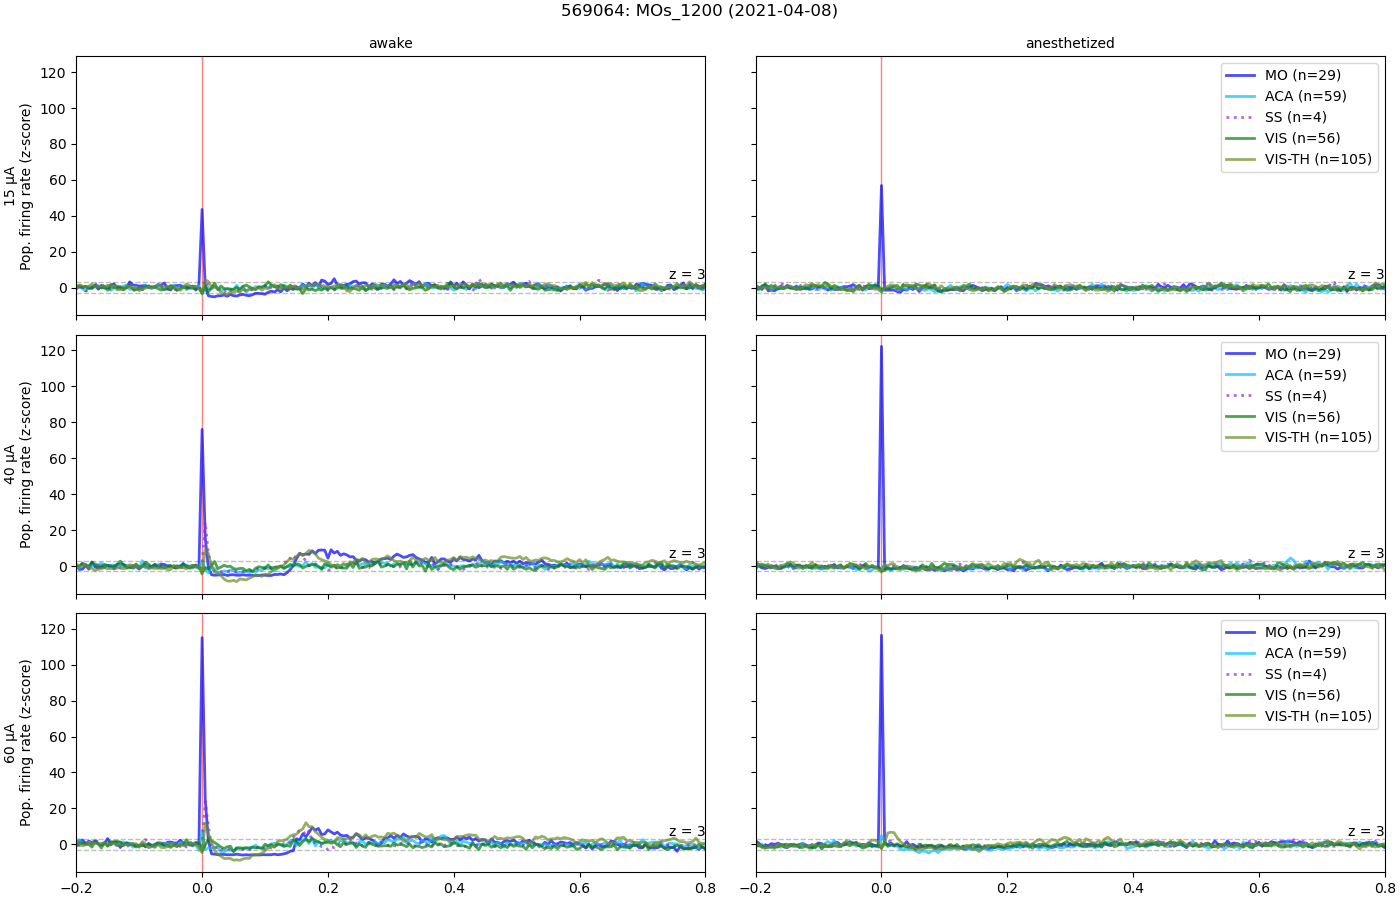

569073a - estim_vis
 probeB
  unit count: 239
 probeC
  unit count: 290
 probeF
  unit count: 102
 Total unit count: 631
 MOs_1220
 biphasic - 20 μA
  awake state: resting trials 91/112
  anesthetized state: resting trials 120/120
 biphasic - 40 μA
  awake state: resting trials 86/111
  anesthetized state: resting trials 120/120
 biphasic - 70 μA
  awake state: resting trials 100/113
  anesthetized state: resting trials 120/120


C:\Users\lesliec\Code\tbd_eeg\tbd_eeg\data_analysis\Utilities\utilities.py:164: RuntimeWarning: invalid value encountered in multiply
  evoked_firingrate = np.empty((len(unit_ids), len(bins)-1))*np.nan


<IPython.core.display.Javascript object>


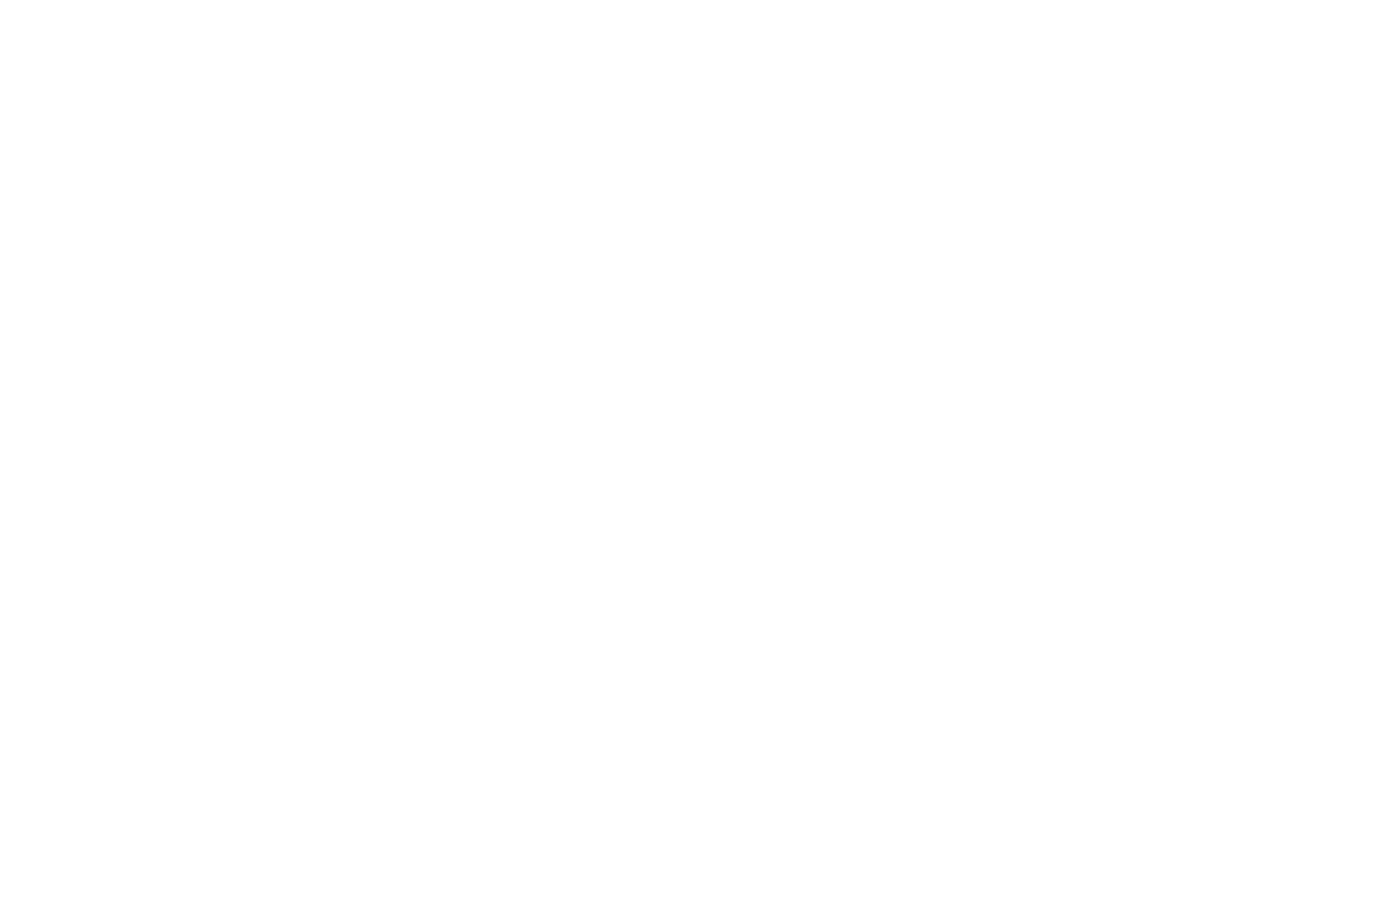

571619 - estim2
 probeB
  unit count: 218
 probeC
  unit count: 343
 probeF
  unit count: 298
 Total unit count: 859
 antMOs_500
 biphasic - 20 μA
  awake state: resting trials 90/112
  anesthetized state: resting trials 120/120
 biphasic - 40 μA
  awake state: resting trials 89/110
  anesthetized state: resting trials 119/119
 biphasic - 60 μA
  awake state: resting trials 94/115
  anesthetized state: resting trials 120/120
 antMOs_1200
 biphasic - 20 μA
  awake state: resting trials 104/119
  anesthetized state: resting trials 120/120
 biphasic - 40 μA
  awake state: resting trials 97/118
  anesthetized state: resting trials 120/120
 biphasic - 60 μA
  awake state: resting trials 103/120
  anesthetized state: resting trials 120/120


<IPython.core.display.Javascript object>


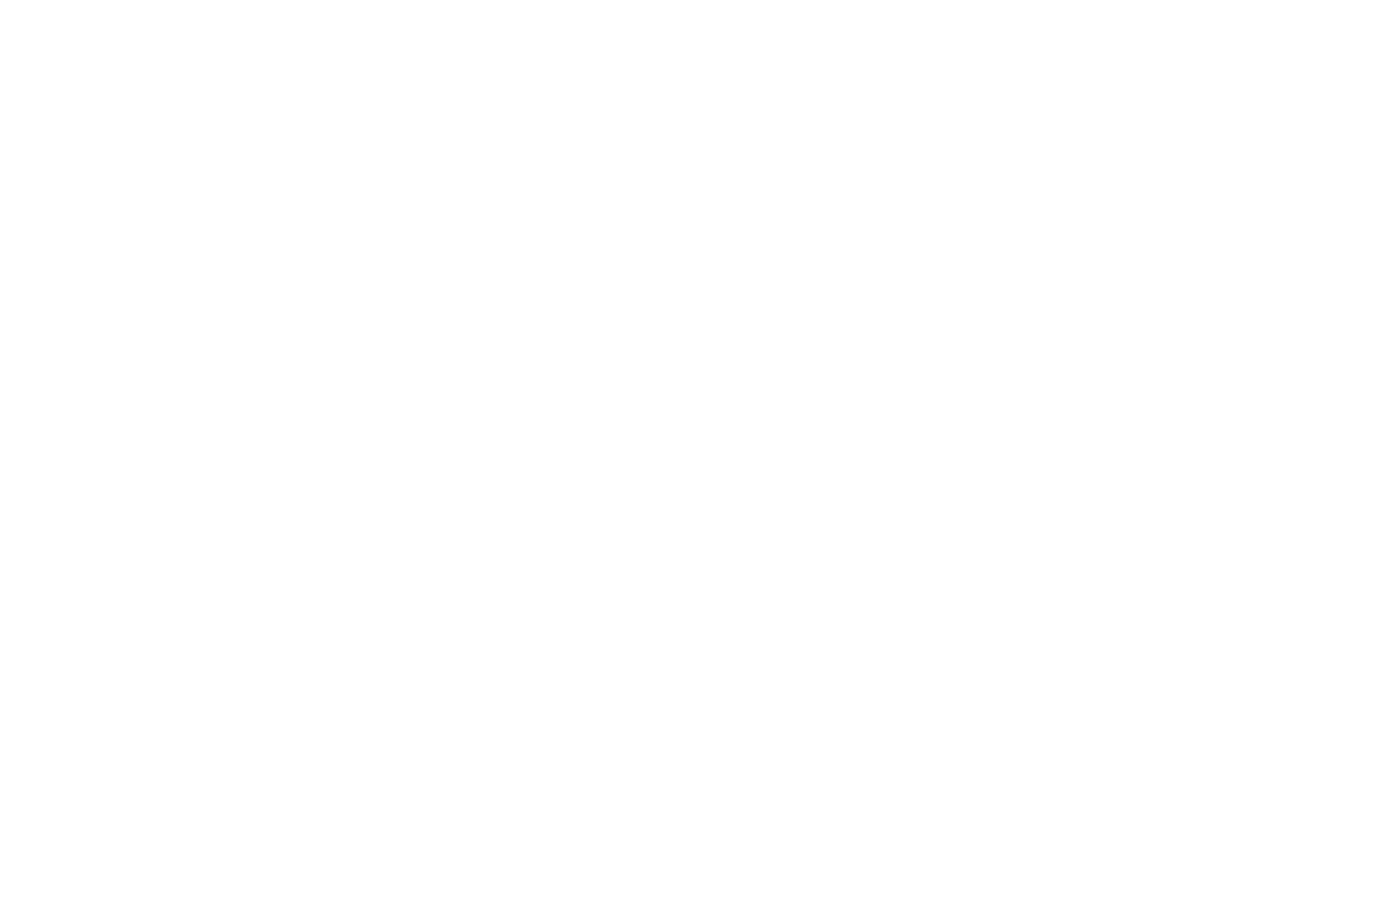

<IPython.core.display.Javascript object>


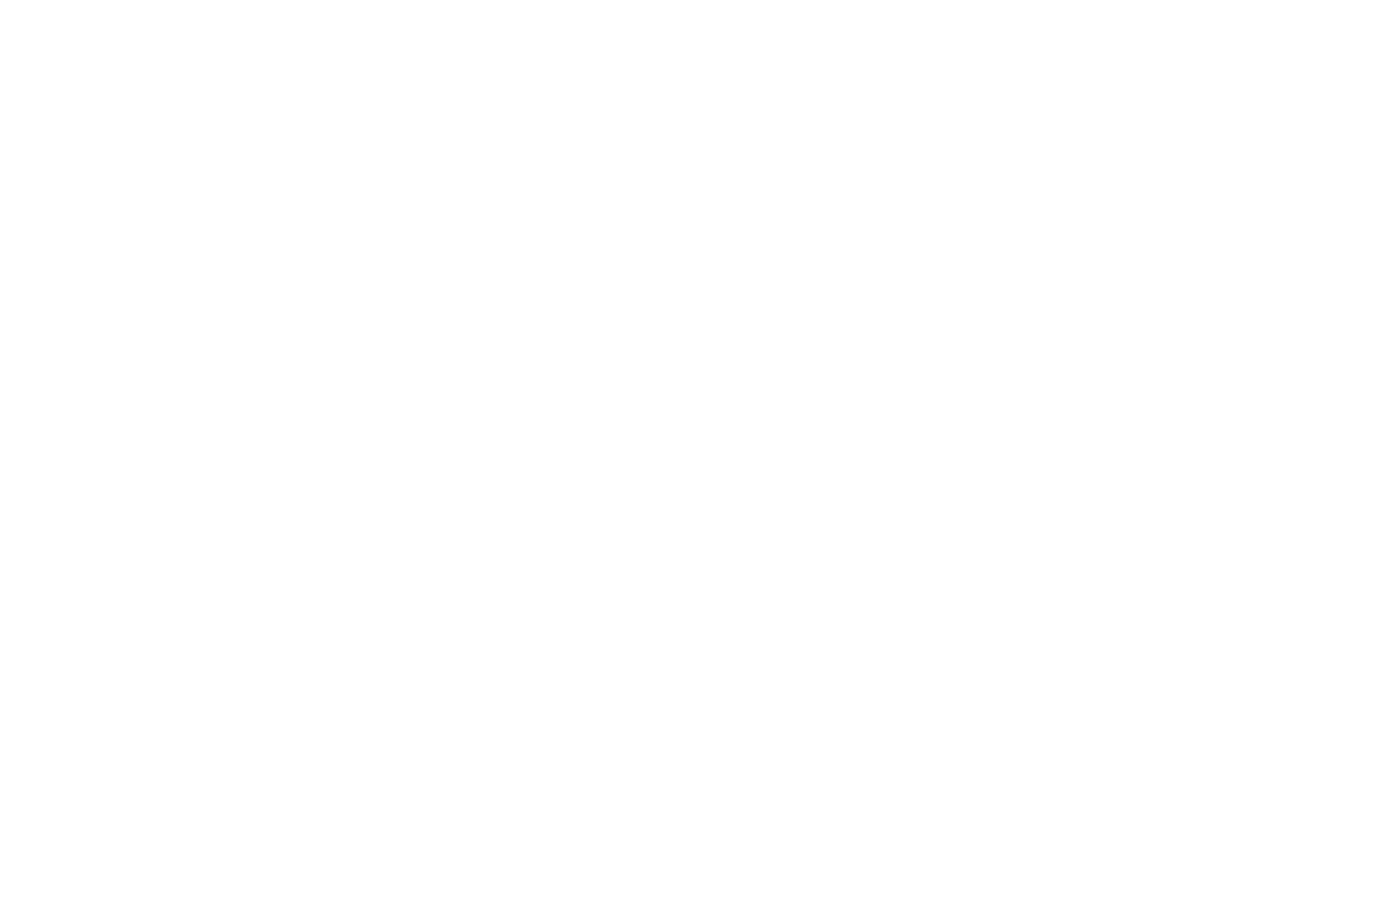

546655 - estim_vis
 probeB
  unit count: 166
 probeC
  unit count: 99
 Total unit count: 265
 MOs_600
 biphasic - 50 μA
  awake state: resting trials 40/120
  anesthetized state: resting trials 117/117
 biphasic - 70 μA
  awake state: resting trials 40/120
  anesthetized state: resting trials 108/109
 biphasic - 90 μA
  awake state: resting trials 38/119
  anesthetized state: resting trials 72/75


<IPython.core.display.Javascript object>


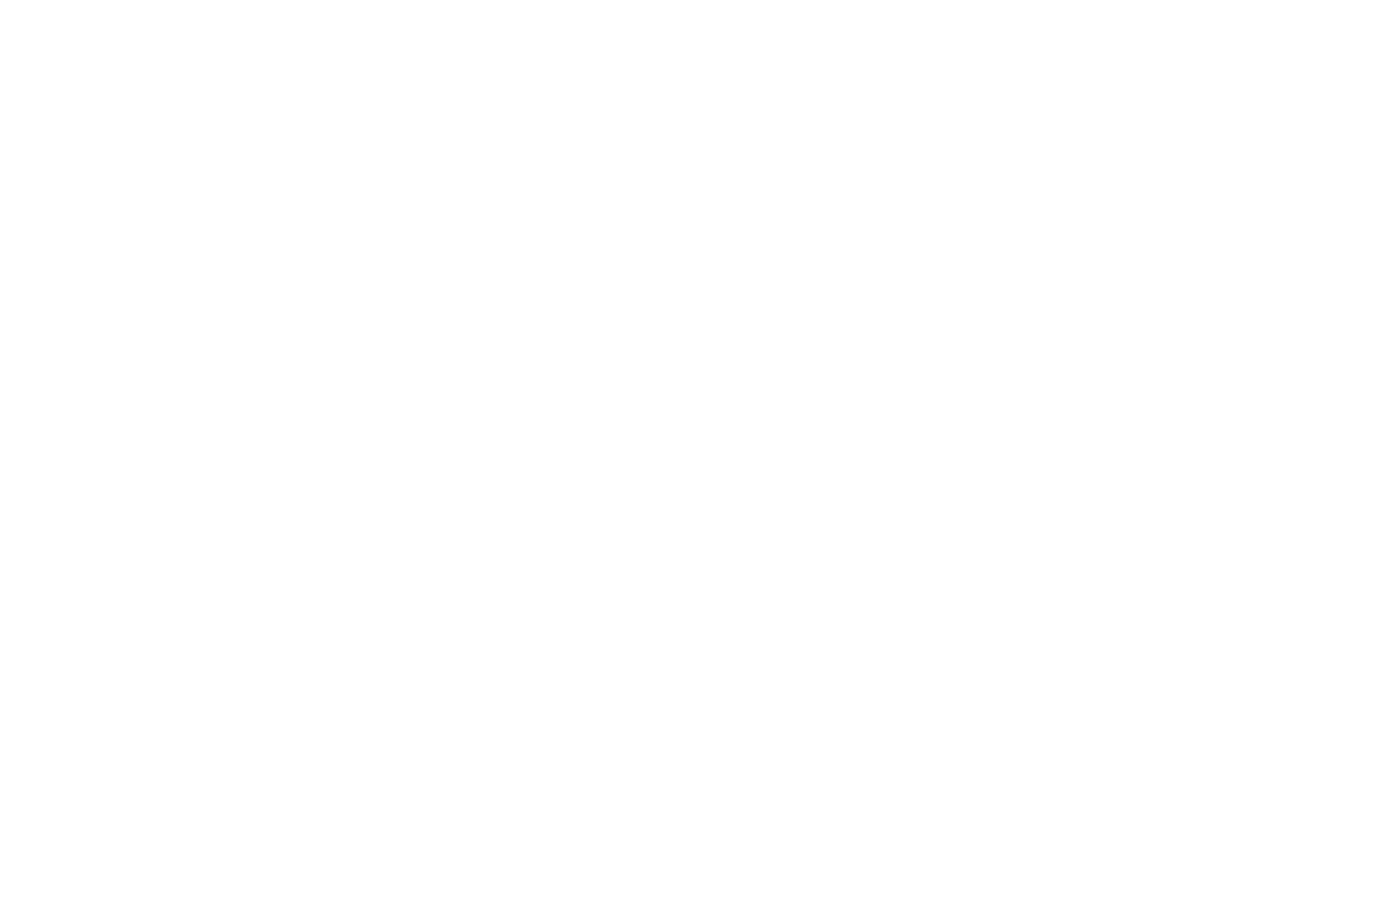

571618 - estim1
 probeB
  unit count: 275
 probeC
  unit count: 196
 probeF
  unit count: 200
 Total unit count: 671
 MOs_600
 biphasic - 40 μA
  awake state: resting trials 10/120
  anesthetized state: resting trials 120/120
 biphasic - 70 μA
  awake state: resting trials 7/119
  anesthetized state: resting trials 120/120
 biphasic - 90 μA
  awake state: resting trials 11/120
  anesthetized state: resting trials 120/120


<IPython.core.display.Javascript object>


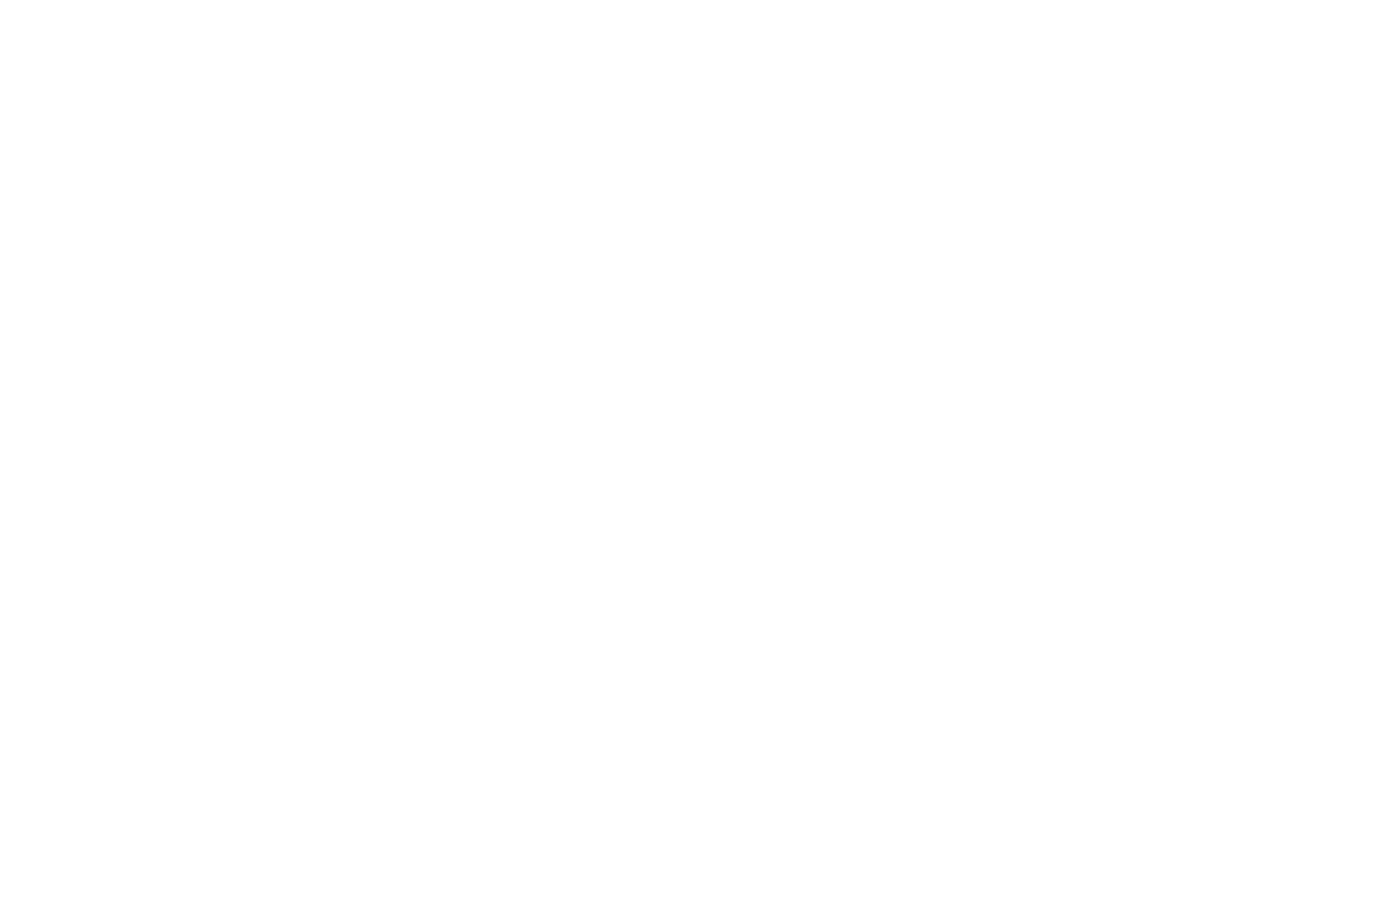

575102 - estim_vis
 probeB
  unit count: 219
 probeC
  unit count: 261
 probeF
  unit count: 48
 Total unit count: 528
 MOs_500
 biphasic - 50 μA
  awake state: resting trials 84/120
  anesthetized state: resting trials 120/120
 biphasic - 70 μA
  awake state: resting trials 83/120
  anesthetized state: resting trials 120/120
 biphasic - 90 μA
  awake state: resting trials 90/120
  anesthetized state: resting trials 120/120


<IPython.core.display.Javascript object>


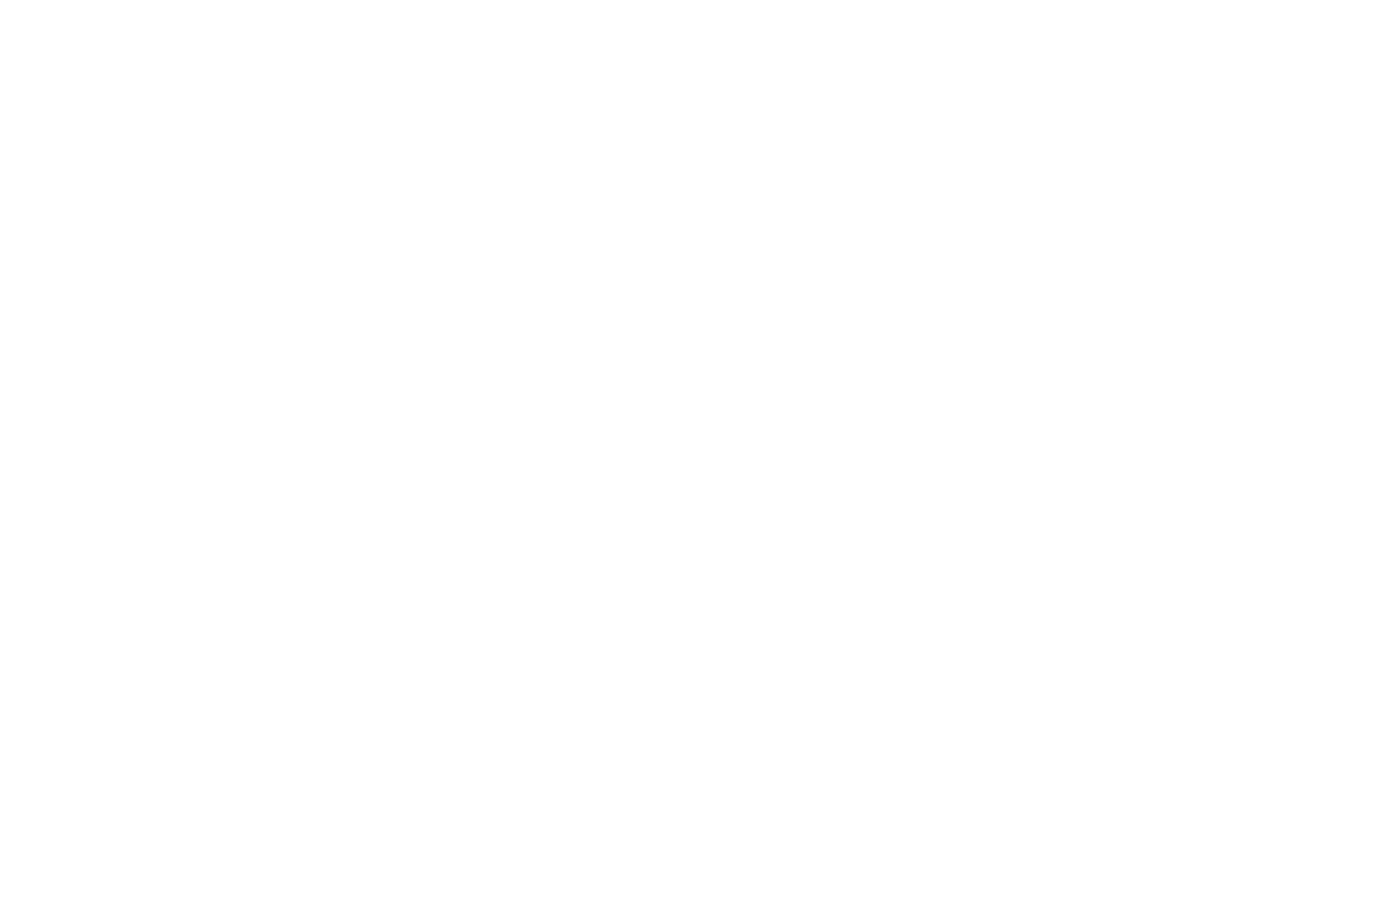

569073b - estim
 probeB
  unit count: 222
 probeC
  unit count: 307
 probeF
  unit count: 176
 Total unit count: 705
 SSp_900
 biphasic - 60 μA
  awake state: resting trials 95/120
  anesthetized state: resting trials 120/120
 biphasic - 80 μA
  awake state: resting trials 93/117
  anesthetized state: resting trials 120/120
 biphasic - 100 μA
  awake state: resting trials 81/118
  anesthetized state: resting trials 120/120


<IPython.core.display.Javascript object>


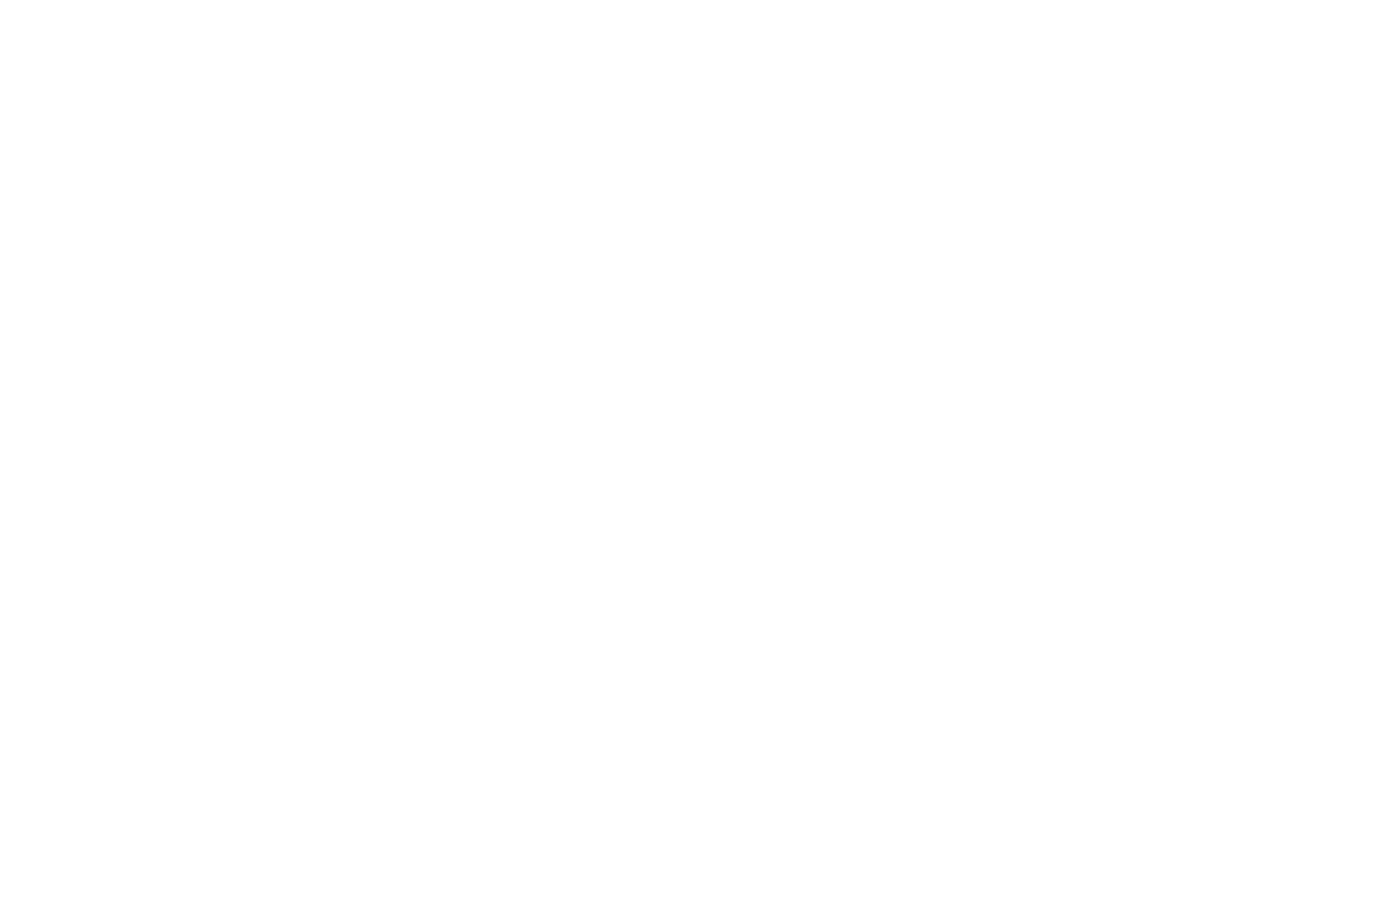

569072 - estim_vis
 probeB
  unit count: 380
 probeC
  unit count: 292
 probeF
  unit count: 323
 Total unit count: 995
 SSp_1000
 biphasic - 30 μA
  awake state: resting trials 108/119
  anesthetized state: resting trials 120/120
 biphasic - 50 μA
  awake state: resting trials 109/120
  anesthetized state: resting trials 119/120
 biphasic - 70 μA
  awake state: resting trials 104/120
  anesthetized state: resting trials 120/120


<IPython.core.display.Javascript object>


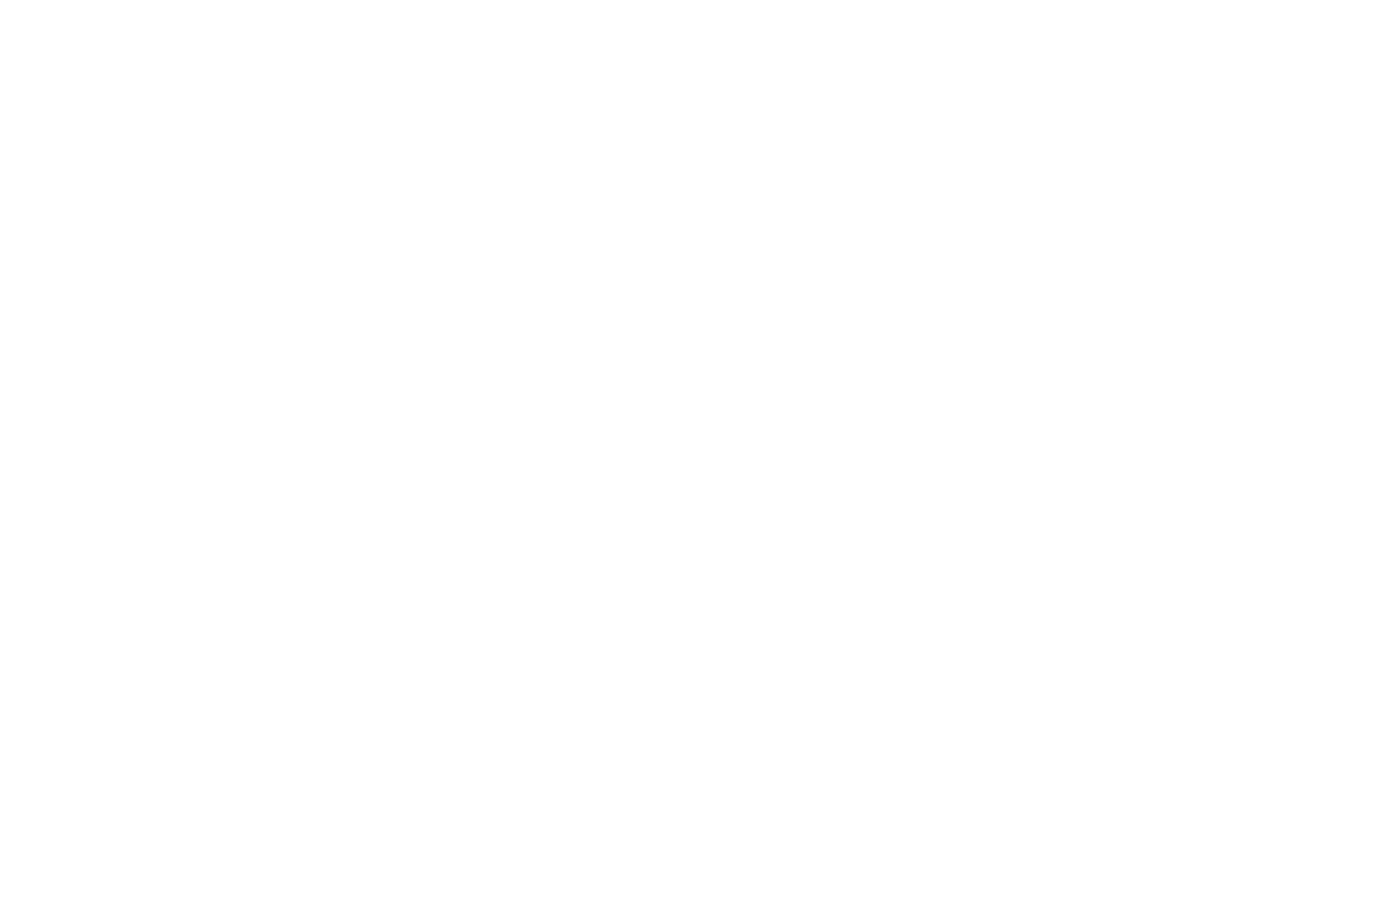

571620 - estim_vis
 probeB
  unit count: 251
 probeC
  unit count: 306
 probeF
  unit count: 214
 Total unit count: 771
 SSp_500
 biphasic - 60 μA
  awake state: resting trials 93/120
  anesthetized state: resting trials 120/120
 biphasic - 80 μA
  awake state: resting trials 93/120
  anesthetized state: resting trials 120/120
 biphasic - 100 μA
  awake state: resting trials 88/120
  anesthetized state: resting trials 120/120
 SSp_900
 biphasic - 60 μA
  awake state: resting trials 104/120
  anesthetized state: resting trials 120/120
 biphasic - 80 μA
  awake state: resting trials 104/120
  anesthetized state: resting trials 120/120
 biphasic - 100 μA
  awake state: resting trials 104/120
  anesthetized state: resting trials 120/120


<IPython.core.display.Javascript object>


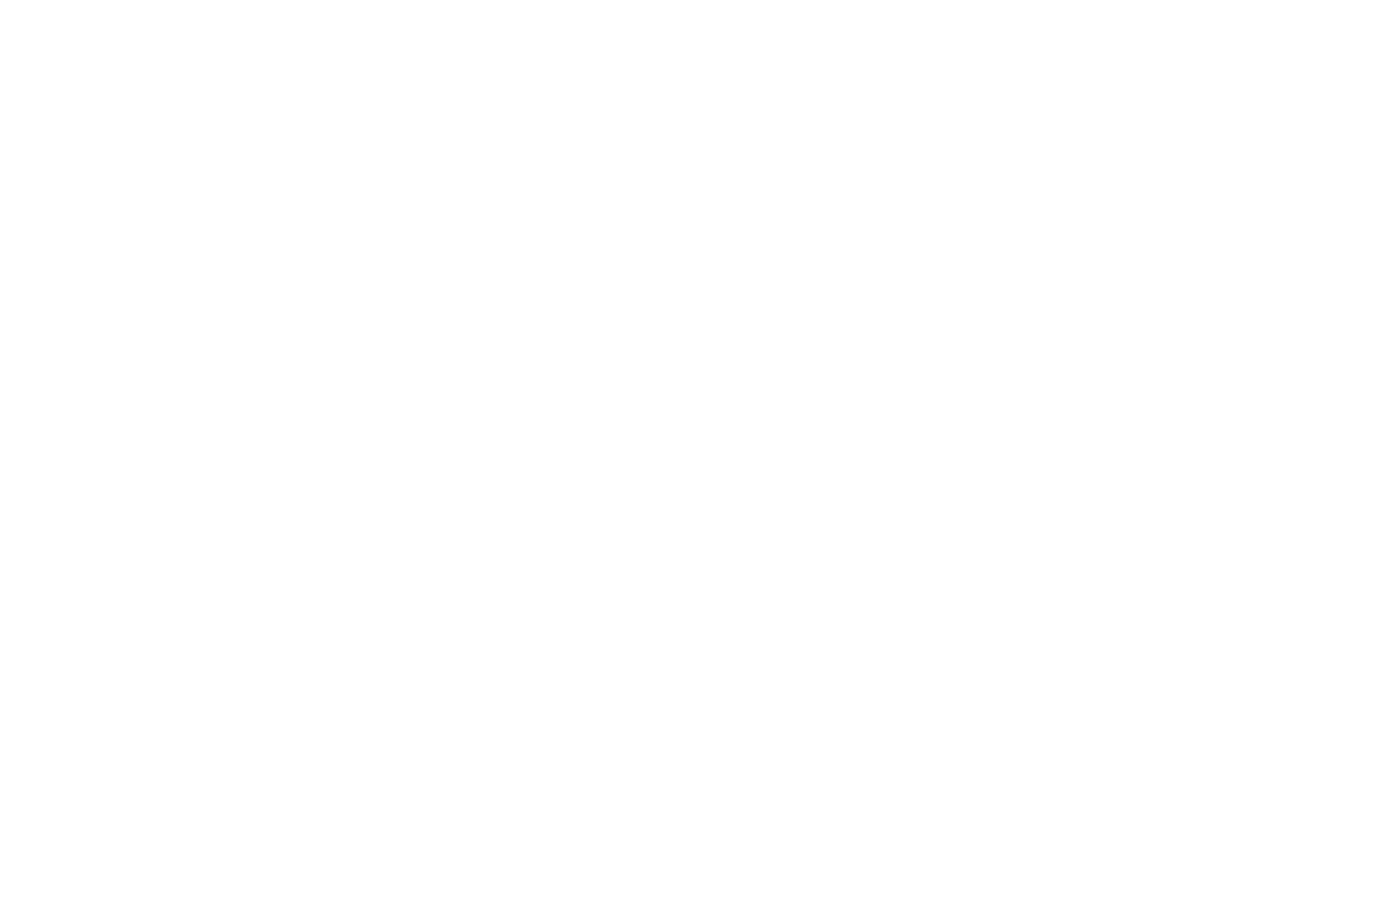

<IPython.core.display.Javascript object>


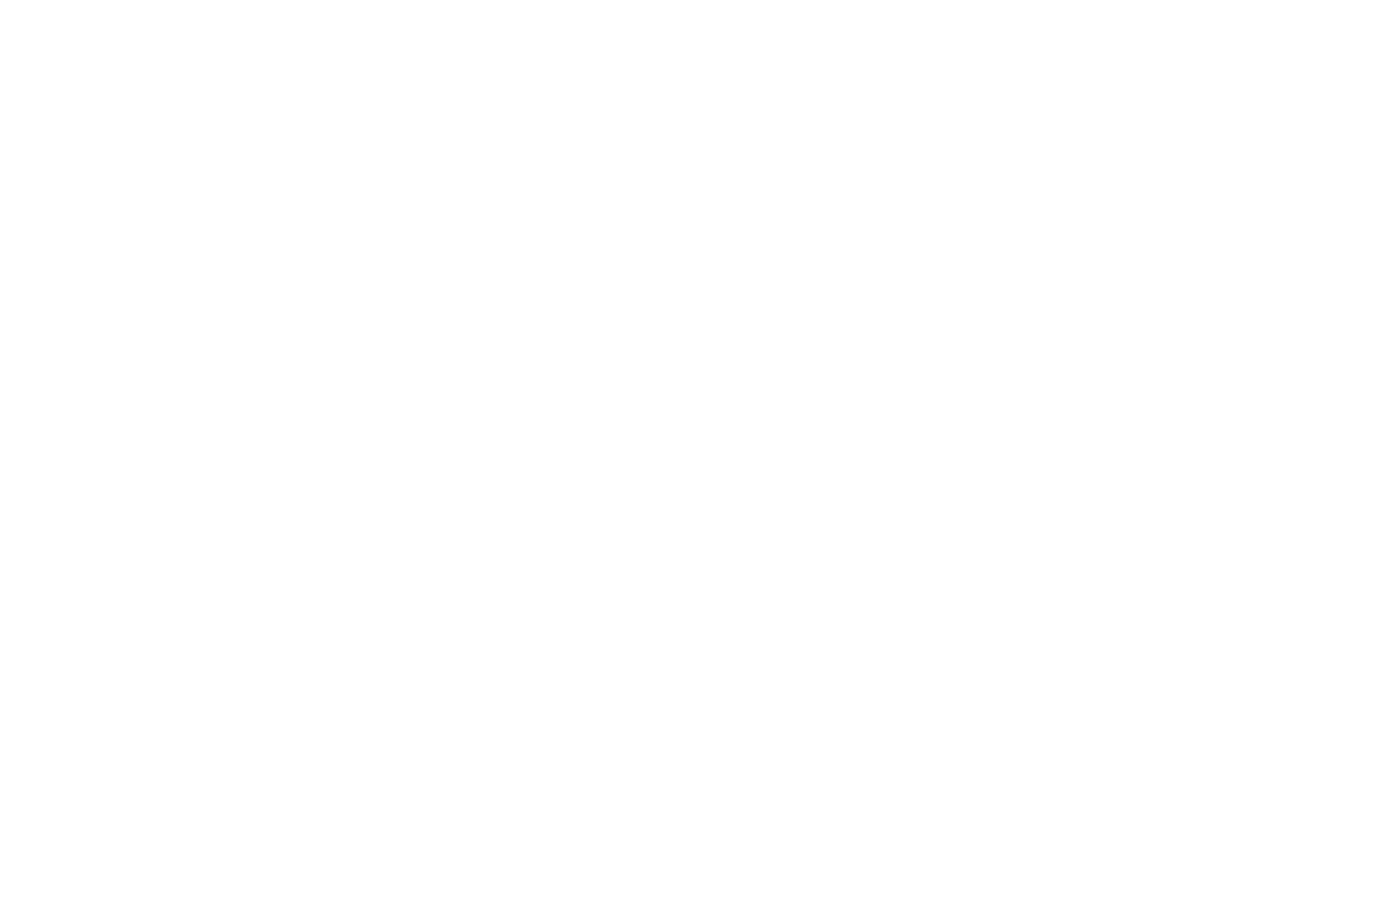

In [15]:
for mousei, expi in sub_exp.items():
    # Make a folder in OneDrive to save plots
    plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + expi.mouse)
    if not os.path.exists(plotsavedir):
        os.mkdir(plotsavedir)
    exp_tag = expi.experiment_folder[expi.experiment_folder.find('mouse')+12:expi.experiment_folder.find(str(expi.date.year))-1]
    print('{} - {}'.format(mousei, exp_tag))
    
    ## Load stim log and running signal ##
    stim_log = pd.read_csv(expi.stimulus_log_file)
    stim_log = stim_log.astype({'parameter': str})
    run_signal, run_timestamps = expi.load_running()
    
    ## Load probe data ##
    probe_list = [x.replace('_sorted', '') for x in expi.experiment_data if 'probe' in x]
    probe_unit_data = {}
    total_units = 0
    for probei in probe_list:
        print(' {}'.format(probei))
        probe_unit_data[probei] = {}

        ## Load probe_info.json ##
        with open(expi.ephys_params[probei]['probe_info']) as data_file:
            data = json.load(data_file)
        npx_allch = np.array(data['channel']) # this is an array from 0 to 384
        surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
        allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip (ch 0 is 20 um from tip)
        ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"

        ## Get all ch depths ##
        npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
        probe_unit_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z

        ## Select units and get peak chs ##
        select_units, peak_chs, unit_metrics = expi.get_probe_units(probei)
        print('  unit count: {:d}'.format(len(select_units)))

        ## Sort units ##
        all_units = select_units[np.squeeze(np.argsort(peak_chs))]
        all_units_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
        if 'area' in unit_metrics.columns:
            all_units_areas = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
            probe_unit_data[probei]['units'] = all_units
            probe_unit_data[probei]['areas'] = all_units_areas
            probe_unit_data[probei]['chs'] = all_units_chs
            total_units += len(probe_unit_data[probei]['units'])
        else:
            print('  unit metrics file does not have area assignments.')
            break

        ## Load spike times and cluster ids ##
        probe_unit_data[probei]['spike_times'] = np.load(expi.ephys_params[probei]['spike_times'])
        probe_unit_data[probei]['spike_clusters'] = np.load(expi.ephys_params[probei]['spike_clusters'])
    print(' Total unit count: {:d}'.format(total_units))
  
    ## Get event times for all events ##
    amp_list = sorted(stim_log[stim_log['stim_type'] == 'biphasic'].parameter.unique(), key=lambda x: int(x))
    all_event_times = {}
    all_trial_counts = {}
    for expdes, state_sweeps in sub_exp_des[mousei].items():
        print(' {}'.format(expdes))
        all_event_times[expdes] = {}
        all_trial_counts[expdes] = {}
        for parami in amp_list:
            print(' biphasic - {} \u03bcA'.format(parami))
            all_event_times[expdes][parami] = {}
            state_trial_count = []
            for statei, sweeps in state_sweeps.items():
                ## Get all event times for statei ##
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_events(stim_log, 'biphasic', parami, sweepi)
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                state_events = np.concatenate(state_events)

                ## Get mean speed for all events ##
                rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
                event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
                mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
                rest_events = np.nonzero(mean_speed == 0)[0]
                print('  {} state: resting trials {:d}/{:d}'.format(statei, len(rest_events), len(state_events)))
                state_trial_count.append(len(rest_events))

                if rest_trials_only:
                    all_event_times[expdes][parami][statei] = state_events[rest_events]
                else:
                    all_event_times[expdes][parami][statei] = state_events
            all_trial_counts[expdes][parami] = state_trial_count
            
    ## Gather population firing rates ##        
    all_pop_activity = {}
    for expdes in all_event_times.keys():
        all_pop_activity[expdes] = {}
        for parami in all_event_times[expdes].keys():
            all_pop_activity[expdes][parami] = {}
            NUM_TRIALS = min([len(all_event_times[expdes][parami][x]) for x in all_event_times[expdes][parami].keys()])
            for statei, event_times in all_event_times[expdes][parami].items():
                all_pop_activity[expdes][parami][statei] = {key: [] for key in list(areas_of_interest.keys())}
                for probei, unit_data in probe_unit_data.items():
                    event_trig_FR, spikerate_ts = get_evoked_firing_rates(
                        unit_data['spike_times'],
                        unit_data['spike_clusters'],
                        unit_data['units'],
                        event_times[:NUM_TRIALS],
                        before_event,
                        after_event,
                        plot_timebin
                    )

                    for unitind in range(event_trig_FR.shape[0]):
                        parent_region = [
                            key for key in list(areas_of_interest.keys()) if unit_data['areas'][unitind] in areas_of_interest[key]
                        ]
                        if len(parent_region) == 1:
                            all_pop_activity[expdes][parami][statei][parent_region[0]].append(event_trig_FR[unitind,:])

    ## Make plots for each mouse and experiment ##
    for expdes in all_pop_activity.keys():
        fig, axs = plt.subplots(3, 2, figsize=(14,9), sharex=True, sharey=True, constrained_layout=True)
        for rowi, (paramii, paramdict) in enumerate(all_pop_activity[expdes].items()):
            for coli, (statei, datai) in enumerate(paramdict.items()):

                axs[rowi,coli].axvline(0, color='r', linewidth=1, alpha=0.5)
                axs[rowi,coli].axhline(3, color='k', linewidth=1, linestyle='dashed', alpha=0.25)
                axs[rowi,coli].axhline(-3, color='k', linewidth=1, linestyle='dashed', alpha=0.25)
                for region, popdata in datai.items():
                    if len(popdata) == 0:
                        continue
                    pop_FR = np.vstack(popdata)
                    if pop_FR.shape[0] < 10:
                        popline = 'dotted'
                    else:
                        popline = 'solid'
                    pop_avg = np.mean(pop_FR, axis=0)
                    BL_bins = spikerate_ts < 0
                    pop_Z = (pop_avg - np.mean(pop_avg[BL_bins[:-1]], axis=0)) / np.std(pop_avg[BL_bins[:-1]], axis=0)
                    axs[rowi,coli].plot(
                        spikerate_ts[:-1], pop_Z, color=area_colors[region], linewidth=2, linestyle=popline, alpha=0.7,
                        label='{} (n={:d})'.format(region, pop_FR.shape[0])
                    )
                axs[rowi,coli].set_xlim(plwin)
                axs[rowi,coli].text(plwin[1], 3, 'z = 3', horizontalalignment='right', verticalalignment='bottom', fontsize=10)

                if coli == 0:
                    axs[rowi,coli].set_ylabel('{} \u03bcA\nPop. firing rate (z-score)'.format(paramii))
                else:
                    axs[rowi,coli].legend()

                if rowi == 0:
                    axs[rowi,coli].set_title(statei)

        plt.suptitle('{}: {} ('.format(expi.mouse, expdes) + expi.date.strftime('%Y-%m-%d') + ')', fontsize=12)
        ## Save ##
        figname = 'Popactivity_summary_{}_{}.png'.format(exp_tag, expdes)
        fig.savefig(os.path.join(plotsavedir, figname), transparent=True)